In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/software-defect-prediction/about JM1 Dataset.txt
/kaggle/input/software-defect-prediction/jm1.csv
/kaggle/input/software-defect-prediction/jm1.arff
/kaggle/input/playground-series-s3e23/sample_submission.csv
/kaggle/input/playground-series-s3e23/train.csv
/kaggle/input/playground-series-s3e23/test.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from category_encoders import OneHotEncoder, GLMMEncoder, TargetEncoder, CatBoostEncoder
from sklearn import set_config
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer, f1_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

sns.set_theme(style = 'white', palette = 'viridis')
pal = sns.color_palette('viridis')

pd.set_option('display.max_rows', 100)
set_config(transform_output = 'pandas')
pd.options.mode.chained_assignment = None

In [3]:
train = pd.read_csv(r'/kaggle/input/playground-series-s3e23/train.csv', index_col = 'id')
test = pd.read_csv(r'/kaggle/input/playground-series-s3e23/test.csv', index_col = 'id')
orig_train = pd.read_csv(r'/kaggle/input/software-defect-prediction/jm1.csv')

In [4]:
train.head(10)

loc  v(g)  ev(g)  iv(g)      n       v     l      d      i        e  ...  \
id                                                                        ...   
0   22.0   3.0    1.0    2.0   60.0  278.63  0.06  19.56  14.25  5448.79  ...   
1   14.0   2.0    1.0    2.0   32.0  151.27  0.14   7.00  21.11   936.71  ...   
2   11.0   2.0    1.0    2.0   45.0  197.65  0.11   8.05  22.76  1754.01  ...   
3    8.0   1.0    1.0    1.0   23.0   94.01  0.19   5.25  17.86   473.66  ...   
4   11.0   2.0    1.0    2.0   17.0   60.94  0.18   5.63  12.44   365.67  ...   
5   23.0   4.0    4.0    3.0   69.0  338.21  0.07  14.15  22.81  3772.51  ...   
6   24.0   4.0    1.0    4.0   60.0  294.41  0.08  12.46  24.62  3295.25  ...   
7   14.0   1.0    1.0    1.0   49.0  221.65  0.18   5.47  46.06  1183.48  ...   
8   34.0  10.0    1.0    4.0  122.0  684.98  0.07  14.33  43.43  9941.84  ...   
9    9.0   2.0    1.0    2.0   16.0   55.35  0.11   9.00   6.15   498.16  ...   

    lOCode  lOComment  lOBlank  locCodeAndComment  uniq_Op  uniq_Opnd  \
id                                                                      
0       17          1        1                  0     16.0        9.0   
1       11          0        1                  0     11.0       11.0   
2        8          0        1                  0     12.0       11.0   
3        4          0        2                  0      8.0        6.0   
4        7          0        2                  0      7.0        6.0   
5       17          1        2                  0     16.0       10.0   
6       19          0        3                  0     14.0       13.0   
7       11          0        2                  0      7.0       18.0   
8       29          1        3                  0     16.0       29.0   
9        4          0        2                  0      9.0        2.0   

    total_Op  total_Opnd  branchCount  defects  
id                                              
0       38.0        22.0          5.0    False  
1       18.0        14.0          3.0    False  
2       28.0        17.0          3.0    False  
3       16.0         7.0          1.0     True  
4       10.0        10.0          3.0    False  
5       40.0        19.0          7.0    False  
6       40.0        23.0          7.0    False  
7       26.0        23.0          1.0    False  
8       75.0        47.0         19.0    False  
9       12.0         4.0          3.0    False  

[10 rows x 22 columns]

In [5]:
desc = pd.DataFrame(index = list(train))
desc['count'] = train.count()
desc['nunique'] = train.nunique()
desc['%unique'] = desc['nunique'] / len(train) * 100
desc['null'] = train.isnull().sum()
desc['type'] = train.dtypes
desc = pd.concat([desc, train.describe().T], axis = 1)
desc

count  nunique   %unique  null     type     count  \
loc                101763      378  0.371451     0  float64  101763.0   
v(g)               101763      106  0.104164     0  float64  101763.0   
ev(g)              101763       71  0.069770     0  float64  101763.0   
iv(g)              101763       84  0.082545     0  float64  101763.0   
n                  101763      836  0.821517     0  float64  101763.0   
v                  101763     4515  4.436780     0  float64  101763.0   
l                  101763       55  0.054047     0  float64  101763.0   
d                  101763     3360  3.301789     0  float64  101763.0   
i                  101763     5171  5.081415     0  float64  101763.0   
e                  101763     8729  8.577774     0  float64  101763.0   
b                  101763      315  0.309543     0  float64  101763.0   
t                  101763     8608  8.458870     0  float64  101763.0   
lOCode             101763      298  0.292837     0    int64  101763.0   
lOComment          101763       91  0.089423     0    int64  101763.0   
lOBlank            101763       94  0.092371     0    int64  101763.0   
locCodeAndComment  101763       29  0.028498     0    int64  101763.0   
uniq_Op            101763       70  0.068787     0  float64  101763.0   
uniq_Opnd          101763      176  0.172951     0  float64  101763.0   
total_Op           101763      623  0.612207     0  float64  101763.0   
total_Opnd         101763      485  0.476598     0  float64  101763.0   
branchCount        101763      144  0.141505     0  float64  101763.0   
defects            101763        2  0.001965     0     bool       NaN   

                           mean            std  min     25%      50%  \
loc                   37.347160      54.600401  1.0   13.00    22.00   
v(g)                   5.492684       7.900855  1.0    2.00     3.00   
ev(g)                  2.845022       4.631262  1.0    1.00     1.00   
iv(g)                  3.498826       5.534541  1.0    1.00     2.00   
n                     96.655995     171.147191  0.0   25.00    51.00   
v                    538.280956    1270.791601  0.0   97.67   232.79   
l                      0.111634       0.100096  0.0    0.05     0.09   
d                     13.681881      14.121306  0.0    5.60     9.82   
i                     27.573007      22.856742  0.0   15.56    23.36   
e                  20853.589876  190571.405427  0.0  564.73  2256.23   
b                      0.179164       0.421844  0.0    0.03     0.08   
t                   1141.357982    9862.795472  0.0   31.38   125.40   
lOCode                22.802453      38.541010  0.0    7.00    14.00   
lOComment              1.773945       5.902412  0.0    0.00     0.00   
lOBlank                3.979865       6.382358  0.0    1.00     2.00   
locCodeAndComment      0.196604       0.998906  0.0    0.00     0.00   
uniq_Op               11.896131       6.749549  0.0    8.00    11.00   
uniq_Opnd             15.596671      18.064261  0.0    7.00    12.00   
total_Op              57.628116     104.537660  0.0   15.00    30.00   
total_Opnd            39.249698      71.692309  0.0   10.00    20.00   
branchCount            9.839549      14.412769  1.0    3.00     5.00   
defects                     NaN            NaN  NaN     NaN      NaN   

                        75%          max  
loc                   42.00      3442.00  
v(g)                   6.00       404.00  
ev(g)                  3.00       165.00  
iv(g)                  4.00       402.00  
n                    111.00      8441.00  
v                    560.25     80843.08  
l                      0.15         1.00  
d                     18.00       418.20  
i                     34.34       569.78  
e                  10193.24  16846621.12  
b                      0.19        26.95  
t                    565.92    935923.39  
lOCode                26.00      2824.00  
lOComment              1.00       344.00  
lOBlank                5.00       219.

In [6]:
test.head(10)

loc  v(g)  ev(g)  iv(g)      n        v     l       d      i  \
id                                                                       
101763   33.0   5.0    1.0    4.0  144.0   824.82  0.04   26.96  30.05   
101764   27.0   8.0    8.0    2.0  125.0   646.24  0.04   22.82  27.22   
101765  130.0  11.0    7.0   10.0  545.0  3831.40  0.02   48.15  66.17   
101766   65.0   7.0    1.0    7.0  156.0   855.71  0.06   17.23  49.89   
101767   22.0   3.0    1.0    3.0   52.0   238.42  0.10    9.60  26.70   
101768   64.0  14.0    5.0    2.0  280.0  1530.28  0.03   34.55  44.36   
101769   25.0   2.0    1.0    2.0   67.0   337.11  0.07   13.54  24.62   
101770  195.0  64.0   64.0   31.0  786.0  4502.15  0.01  142.86  31.52   
101771   56.0   5.0    1.0    5.0  144.0   755.70  0.09   11.64  70.03   
101772   17.0   2.0    1.0    2.0   55.0   267.19  0.14    7.38  30.98   

                e  ...         t  lOCode  lOComment  lOBlank  \
id                 ...                                         
101763   22636.74  ...   1257.60      30          0        3   
101764   14482.46  ...    804.58      23          0        2   
101765  116160.08  ...   6453.34      99          9       17   
101766   16135.47  ...    896.42      45          8       10   
101767    2624.49  ...    145.80      16          0        4   
101768   52130.58  ...   2896.14      50          8        8   
101769    4419.98  ...    245.55      19          0        3   
101770  643163.64  ...  35731.31     169          7       11   
101771   11804.52  ...    655.81      44          1        7   
101772    1969.07  ...    109.39      14          0        1   

        locCodeAndComment  uniq_Op  uniq_Opnd  total_Op  total_Opnd  \
id                                                                    
101763                  0     21.0       23.0      87.0        57.0   
101764                  0     18.0       19.0      70.0        49.0   
101765                  1     26.0       53.0     333.0       244.0   
101766                  0     15.0       26.0      88.0        60.0   
101767                  0     12.0       15.0      30.0        24.0   
101768                  2     21.0       37.0     158.0       110.0   
101769                  0     12.0       13.0      36.0        33.0   
101770                  5     26.0       28.0     522.0       320.0   
101771                  0     13.0       33.0      80.0        63.0   
101772                  0      8.0       13.0      28.0        27.0   

        branchCount  
id                   
101763          9.0  
101764         15.0  
101765         21.0  
101766         13.0  
101767          5.0  
101768         27.0  
101769          3.0  
101770        127.0  
101771          9.0  
101772          3.0  

[10 rows x 21 columns]

In [7]:
desc = pd.DataFrame(index = list(test))
desc['count'] = test.count()
desc['nunique'] = test.nunique()
desc['%unique'] = desc['nunique'] / len(test) * 100
desc['null'] = test.isnull().sum()
desc['type'] = test.dtypes
desc = pd.concat([desc, test.describe().T], axis = 1)
desc

count  nunique    %unique  null     type    count  \
loc                67842      371   0.546859     0  float64  67842.0   
v(g)               67842       96   0.141505     0  float64  67842.0   
ev(g)              67842       67   0.098759     0  float64  67842.0   
iv(g)              67842       73   0.107603     0  float64  67842.0   
n                  67842      828   1.220483     0  float64  67842.0   
v                  67842     4269   6.292562     0  float64  67842.0   
l                  67842       54   0.079597     0  float64  67842.0   
d                  67842     3106   4.578285     0  float64  67842.0   
i                  67842     4855   7.156334     0  float64  67842.0   
e                  67842     8160  12.027947     0  float64  67842.0   
b                  67842      310   0.456944     0  float64  67842.0   
t                  67842     7969  11.746411     0  float64  67842.0   
lOCode             67842      296   0.436308     0    int64  67842.0   
lOComment          67842       83   0.122343     0    int64  67842.0   
lOBlank            67842       98   0.144453     0    int64  67842.0   
locCodeAndComment  67842       26   0.038324     0    int64  67842.0   
uniq_Op            67842       68   0.100233     0  float64  67842.0   
uniq_Opnd          67842      174   0.256478     0  float64  67842.0   
total_Op           67842      598   0.881460     0  float64  67842.0   
total_Opnd         67842      468   0.689838     0  float64  67842.0   
branchCount        67842      138   0.203414     0  float64  67842.0   

                           mean            std  min     25%      50%  \
loc                   37.855945      55.793918  1.0   13.00    22.00   
v(g)                   5.559462       8.237389  1.0    2.00     3.00   
ev(g)                  2.857699       4.666370  1.0    1.00     1.00   
iv(g)                  3.535715       5.339085  1.0    1.00     2.00   
n                     98.222178     179.123492  0.0   25.00    51.00   
v                    548.422497    1318.416828  0.0   96.21   232.79   
l                      0.111521       0.100840  0.0    0.04     0.09   
d                     13.762472      14.487425  0.0    5.50     9.82   
i                     27.635377      23.420521  0.0   15.54    23.23   
e                  22164.320048  207276.970847  0.0  562.94  2276.78   
b                      0.182075       0.418493  0.0    0.03     0.08   
t                   1218.682009   10739.081373  0.0   31.27   126.49   
lOCode                23.131924      39.606659  0.0    7.00    14.00   
lOComment              1.832493       6.229052  0.0    0.00     0.00   
lOBlank                4.020739       7.136069  0.0    1.00     2.00   
locCodeAndComment      0.200834       1.044581  0.0    0.00     0.00   
uniq_Op               11.909776       6.974254  0.0    8.00    12.00   
uniq_Opnd             15.678370      17.979368  0.0    7.00    12.00   
total_Op              58.325212     105.491447  0.0   15.00    30.00   
total_Opnd            39.845258      72.756320  0.0   10.00    20.00   
branchCount            9.985923      15.342975  1.0    3.00     5.00   

                          75%          max  
loc                   42.0000      1891.00  
v(g)                   6.0000       470.00  
ev(g)                  3.0000       165.00  
iv(g)                  4.0000       402.00  
n                    111.0000      8441.00  
v                    560.2500     80843.08  
l                      0.1400         1.00  
d                     18.0000       418.20  
i                     34.2700       569.78  
e                  10112.4275  16846621.12  
b                      0.1900        18.38  
t                    561.8025    935923.39  
lOCode                26.0000      1599.00  
lOComment              1.0000       344.00  
lOBlank                5.0000       447.00  
locCodeAndComment      0.0000        42.00  
uniq_Op               16.0000       411.00  
uniq_Opnd             20.0000      1026

In [8]:
orig_train.head(10)

loc  v(g)  ev(g)  iv(g)      n        v     l      d       i         e  \
0    1.1   1.4    1.4    1.4    1.3     1.30  1.30   1.30    1.30      1.30   
1    1.0   1.0    1.0    1.0    1.0     1.00  1.00   1.00    1.00      1.00   
2   72.0   7.0    1.0    6.0  198.0  1134.13  0.05  20.31   55.85  23029.10   
3  190.0   3.0    1.0    3.0  600.0  4348.76  0.06  17.06  254.87  74202.67   
4   37.0   4.0    1.0    4.0  126.0   599.12  0.06  17.19   34.86  10297.30   
5   31.0   2.0    1.0    2.0  111.0   582.52  0.08  12.25   47.55   7135.87   
6   78.0   9.0    5.0    4.0    0.0     0.00  0.00   0.00    0.00      0.00   
7    8.0   1.0    1.0    1.0   16.0    50.72  0.36   2.80   18.11    142.01   
8   24.0   2.0    1.0    2.0    0.0     0.00  0.00   0.00    0.00      0.00   
9  143.0  22.0   20.0   10.0    0.0     0.00  0.00   0.00    0.00      0.00   

   ...  lOCode  lOComment  lOBlank  locCodeAndComment  uniq_Op  uniq_Opnd  \
0  ...       2          2        2                  2      1.2        1.2   
1  ...       1          1        1                  1        1          1   
2  ...      51         10        8                  1       17         36   
3  ...     129         29       28                  2       17        135   
4  ...      28          1        6                  0       11         16   
5  ...      19          0        5                  0       14         24   
6  ...       0          0        0                  0        0          0   
7  ...       5          0        1                  0        4          5   
8  ...       0          0        0                  0        0          0   
9  ...       0          0        0                  0        0          0   

  total_Op total_Opnd branchCount defects  
0      1.2        1.2         1.4   False  
1        1          1           1    True  
2      112         86          13    True  
3      329        271           5    True  
4       76         50           7    True  
5       69         42           3    True  
6        0          0          17    True  
7        9          7           1    True  
8        0          0           3    True  
9        0          0          43    True  

[10 rows x 22 columns]

In [9]:
desc = pd.DataFrame(index = list(orig_train))
desc['count'] = orig_train.count()
desc['nunique'] = orig_train.nunique()
desc['%unique'] = desc['nunique'] / len(orig_train) * 100
desc['null'] = orig_train.isnull().sum()
desc['type'] = orig_train.dtypes
desc = pd.concat([desc, orig_train.describe().T], axis = 1)
desc

count  nunique    %unique  null     type    count  \
loc                10885      365   3.353238     0  float64  10885.0   
v(g)               10885      108   0.992191     0  float64  10885.0   
ev(g)              10885       74   0.679835     0  float64  10885.0   
iv(g)              10885       82   0.753330     0  float64  10885.0   
n                  10885      806   7.404685     0  float64  10885.0   
v                  10885     3991  36.665136     0  float64  10885.0   
l                  10885       55   0.505282     0  float64  10885.0   
d                  10885     2695  24.758842     0  float64  10885.0   
i                  10885     4268  39.209922     0  float64  10885.0   
e                  10885     6978  64.106569     0  float64  10885.0   
b                  10885      310   2.847956     0  float64  10885.0   
t                  10885     6761  62.113000     0  float64  10885.0   
lOCode             10885      291   2.673404     0    int64  10885.0   
lOComment          10885       88   0.808452     0    int64  10885.0   
lOBlank            10885       95   0.872761     0    int64  10885.0   
locCodeAndComment  10885       30   0.275609     0    int64  10885.0   
uniq_Op            10885       69   0.633900     0   object      NaN   
uniq_Opnd          10885      172   1.580156     0   object      NaN   
total_Op           10885      582   5.346808     0   object      NaN   
total_Opnd         10885      469   4.308682     0   object      NaN   
branchCount        10885      147   1.350482     0   object      NaN   
defects            10885        2   0.018374     0     bool      NaN   

                           mean            std  min     25%      50%  \
loc                   42.016178      76.593332  1.0   11.00    23.00   
v(g)                   6.348590      13.019695  1.0    2.00     3.00   
ev(g)                  3.401047       6.771869  1.0    1.00     1.00   
iv(g)                  4.001599       9.116889  1.0    1.00     2.00   
n                    114.389738     249.502091  0.0   14.00    49.00   
v                    673.758017    1938.856196  0.0   48.43   217.13   
l                      0.135335       0.160538  0.0    0.03     0.08   
d                     14.177237      18.709900  0.0    3.00     9.09   
i                     29.439544      34.418313  0.0   11.86    21.93   
e                  36836.365343  434367.801255  0.0  161.94  2031.02   
b                      0.224766       0.646408  0.0    0.02     0.07   
t                   2046.464876   24131.544463  0.0    9.00   112.83   
lOCode                26.252274      59.611201  0.0    4.00    13.00   
lOComment              2.737529       9.008608  0.0    0.00     0.00   
lOBlank                4.625540       9.968130  0.0    0.00     2.00   
locCodeAndComment      0.370785       1.907969  0.0    0.00     0.00   
uniq_Op                     NaN            NaN  NaN     NaN      NaN   
uniq_Opnd                   NaN            NaN  NaN     NaN      NaN   
total_Op                    NaN            NaN  NaN     NaN      NaN   
total_Opnd                  NaN            NaN  NaN     NaN      NaN   
branchCount                 NaN            NaN  NaN     NaN      NaN   
defects                     NaN            NaN  NaN     NaN      NaN   

                        75%          max  
loc                   46.00      3442.00  
v(g)                   7.00       470.00  
ev(g)                  3.00       165.00  
iv(g)                  4.00       402.00  
n                    119.00      8441.00  
v                    621.48     80843.08  
l                      0.16         1.30  
d                     18.90       418.20  
i                     36.78       569.78  
e                  11416.43  31079782.27  
b                      0.21        26.95  
t                    634.25   1726654.57  
lOCode                28.00      2824.00  
lOComment              2.00       344.00  
lOBlank                5.00       447.00  
locCodeAndComment

In [10]:
orig_train.uniq_Op.unique()

array(['1.2', '1', '17', '11', '14', '0', '4', '19', '32', '7', '26',
       '27', '21', '9', '28', '22', '16', '8', '20', '10', '13', '25',
       '12', '5', '34', '15', '6', '18', '24', '30', '?', '23', '3', '38',
       '29', '33', '39', '45', '31', '58', '37', '49', '48', '410', '35',
       '36', '42', '40', '46', '44', '41', '52', '74', '280', '65', '73',
       '61', '78', '172', '105', '102', '98', '411', '155', '2', '55',
       '43', '47', '99'], dtype=object)

In [12]:
for object_features in list(orig_train.loc[:, orig_train.dtypes == 'O']):
    orig_train[object_features] = orig_train[object_features].replace({'?' : np.nan}).astype('float64')

In [14]:
def adversarial_validation(dataset_1 = train, dataset_2 = test, label = 'Train-Test'):

    adv_train = dataset_1.drop('defects', axis = 1)
    adv_test = dataset_2.copy()

    adv_train['is_test'] = 0
    adv_test['is_test'] = 1

    adv = pd.concat([adv_train, adv_test], ignore_index = True)

    adv_shuffled = adv.sample(frac = 1)

    adv_X = adv_shuffled.drop('is_test', axis = 1)
    adv_y = adv_shuffled.is_test

    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)

    val_scores = []
    predictions = np.zeros(len(adv))

    for fold, (train_idx, val_idx) in enumerate(skf.split(adv_X, adv_y)):
    
        adv_lr = XGBClassifier(random_state = 42)
        adv_lr.fit(adv_X.iloc[train_idx], adv_y.iloc[train_idx])
        
        val_preds = adv_lr.predict_proba(adv_X.iloc[val_idx])[:,1]
        predictions[val_idx] = val_preds
        val_score = roc_auc_score(adv_y.iloc[val_idx], val_preds)
        val_scores.append(val_score)
    fpr, tpr, _ = roc_curve(adv['is_test'], predictions)
    
    plt.figure(figsize = (10, 10), dpi = 300)
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", label="Indistinguishable Datasets")
    sns.lineplot(x=fpr, y=tpr, label="Adversarial Validation Classifier")
    plt.title(f'{label} Validation = {np.mean(val_scores):.5f}', weight = 'bold', size = 17)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

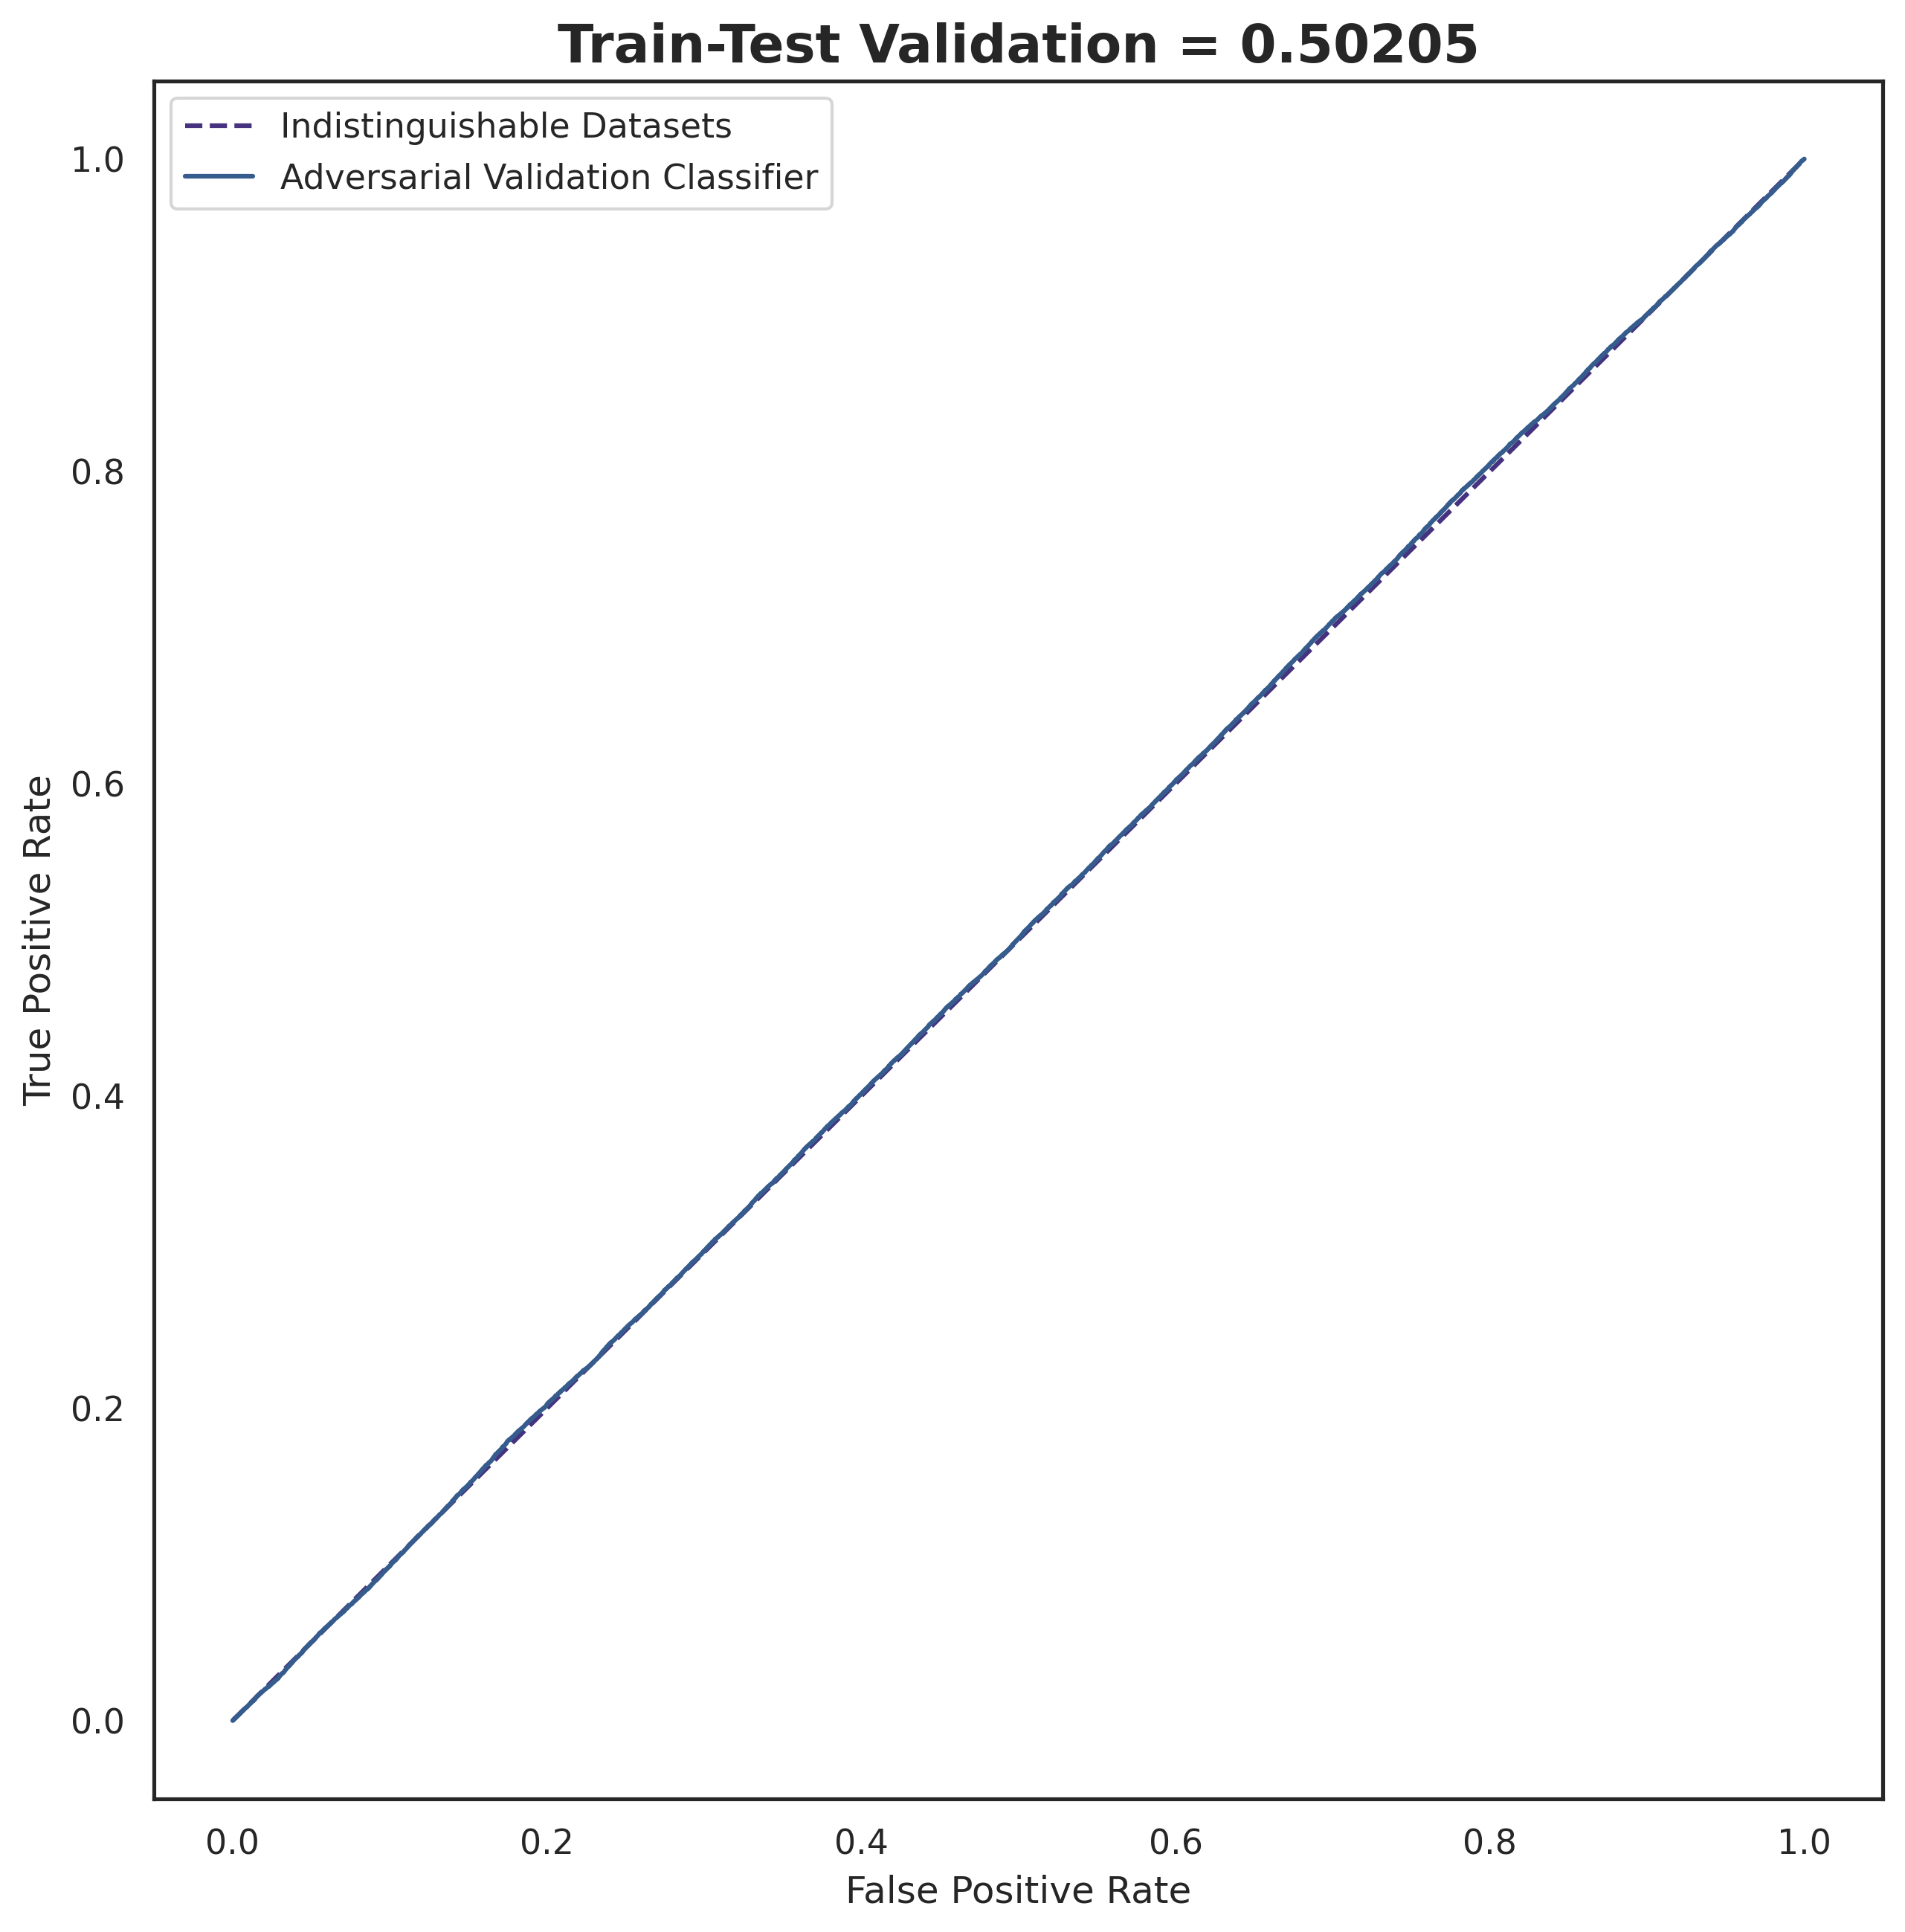

In [15]:
adversarial_validation()

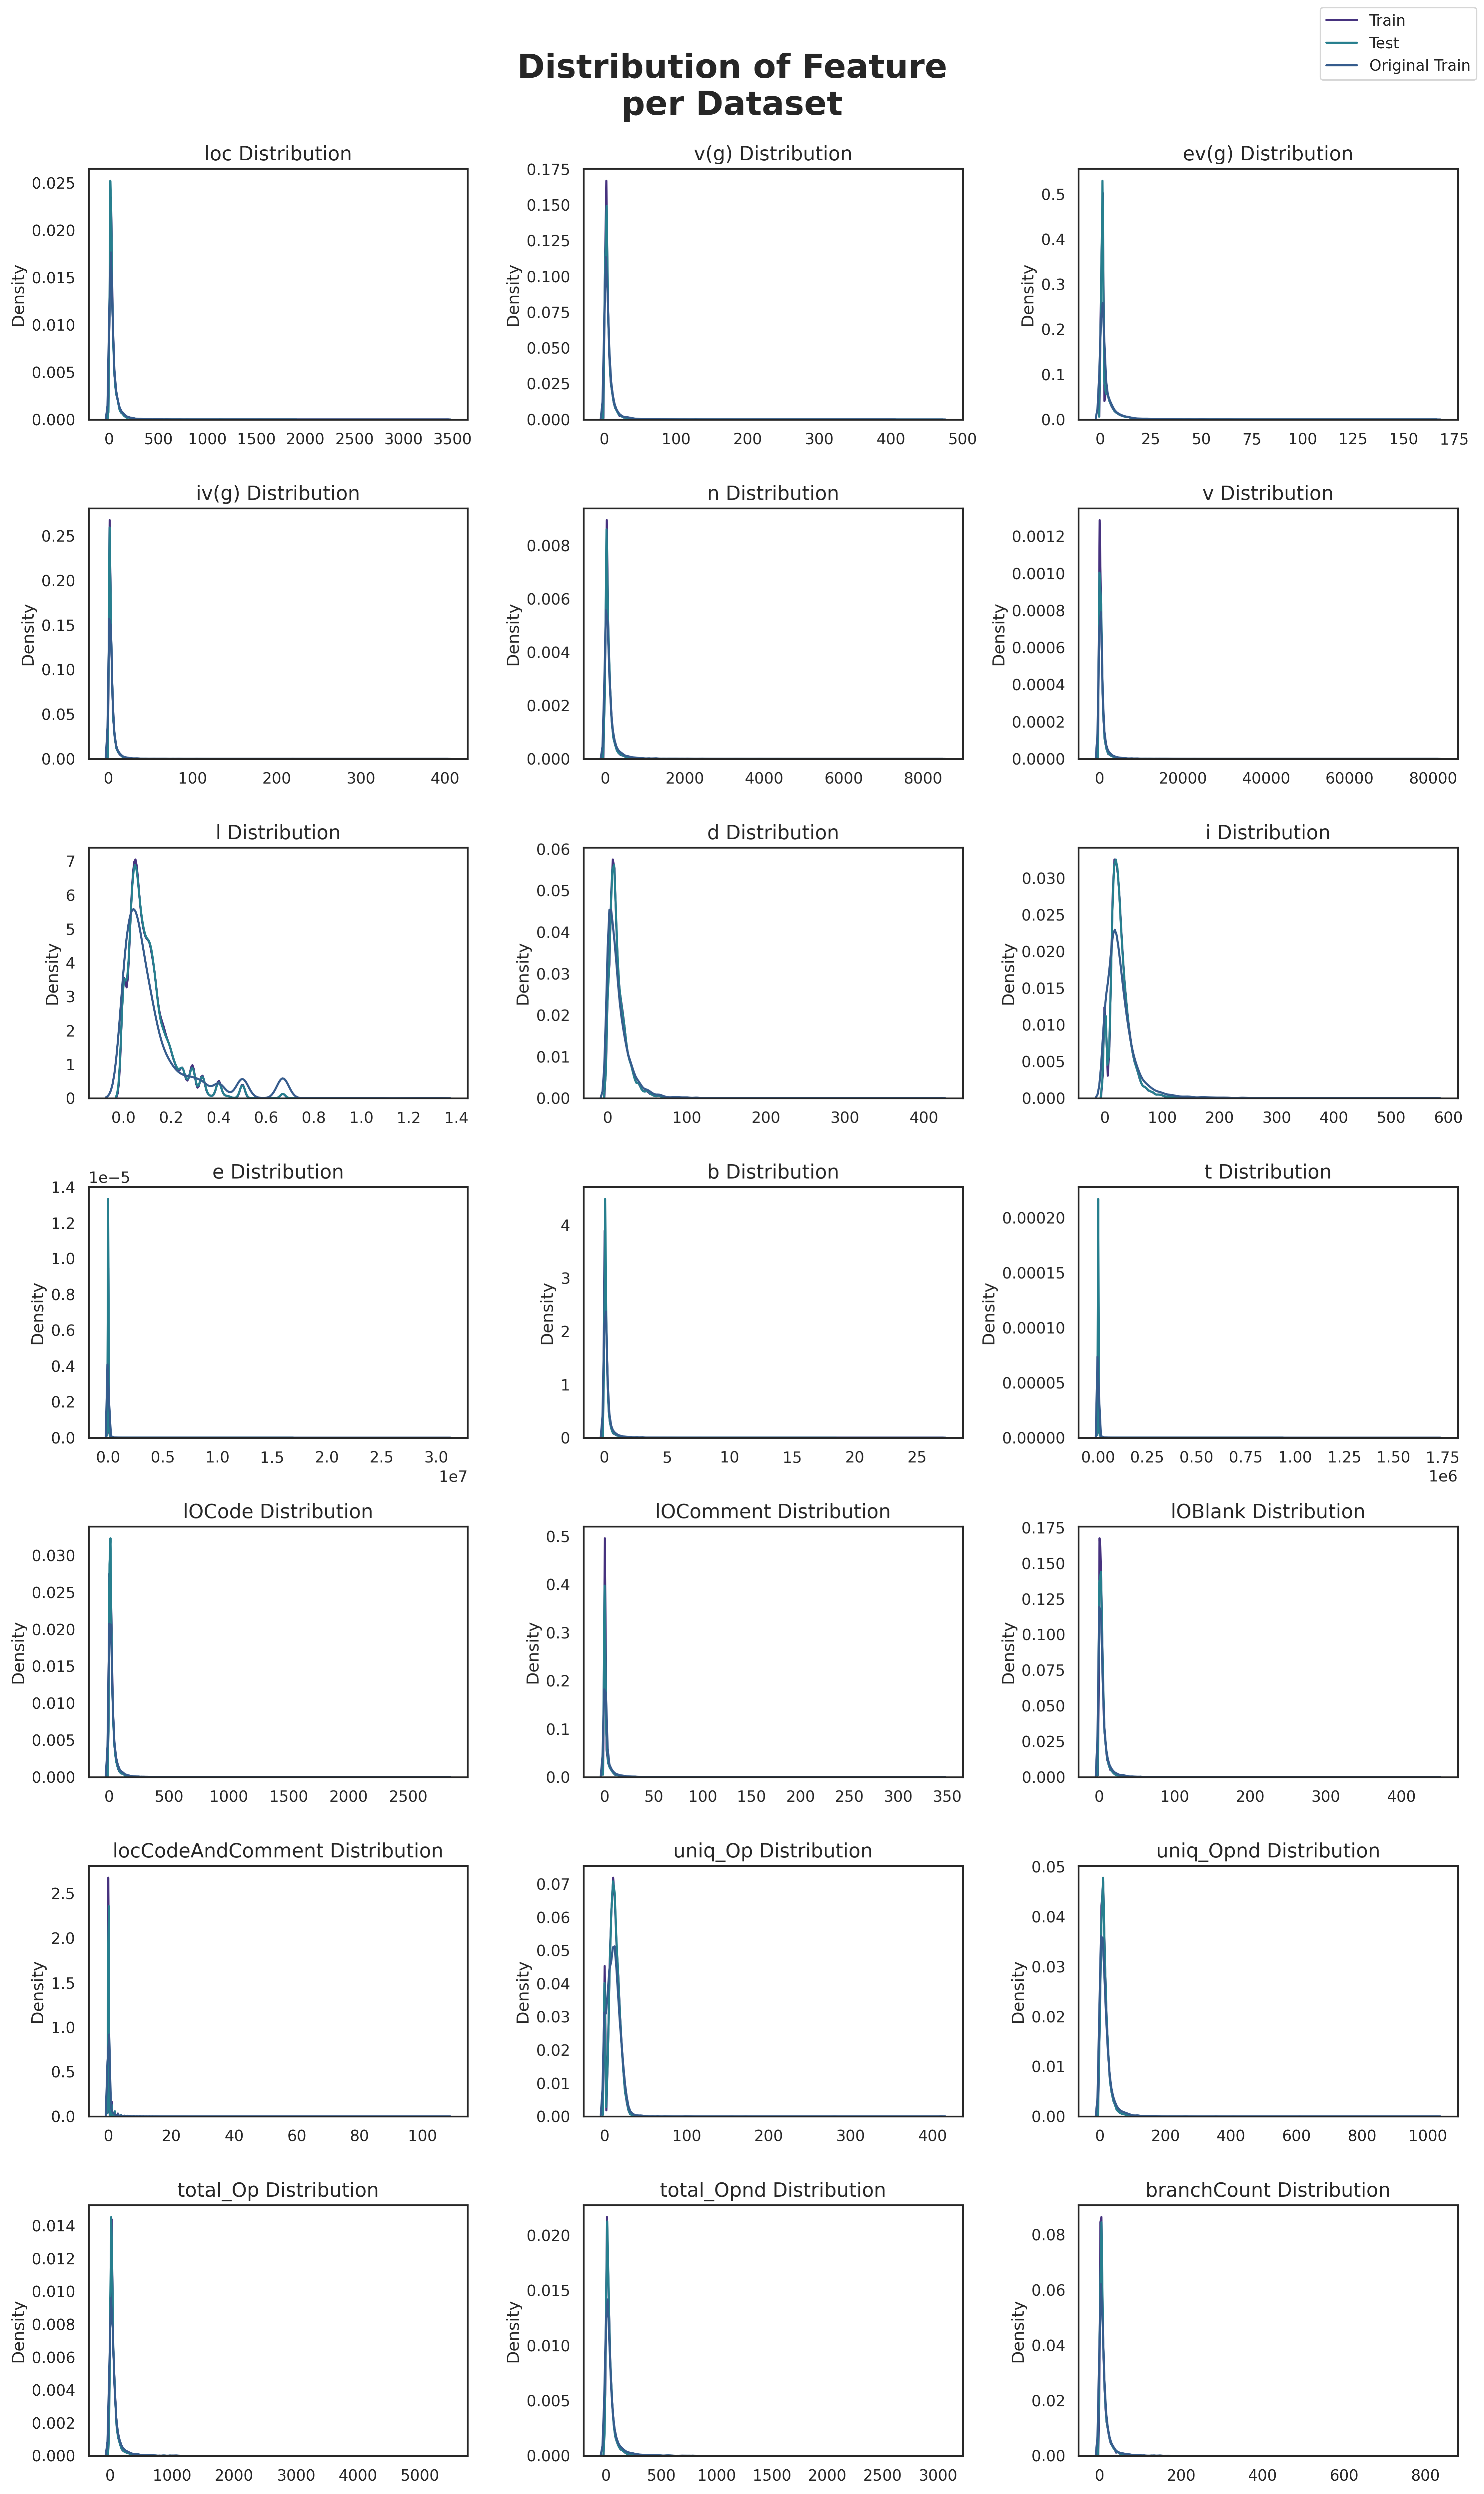

In [16]:
fig, ax = plt.subplots(7, 3, figsize = (15, 25), dpi = 300)
ax = ax.flatten()

for i, column in enumerate(list(test)):
        
    sns.kdeplot(train[column], ax=ax[i], color=pal[0])
    sns.kdeplot(test[column], ax=ax[i], color=pal[2], warn_singular = False)
    sns.kdeplot(orig_train[column], ax=ax[i], color=pal[1])
    
    ax[i].set_title(f'{column} Distribution', size = 14)
    ax[i].set_xlabel(None)
    
fig.suptitle('Distribution of Feature\nper Dataset\n', fontsize = 24, fontweight = 'bold')
fig.legend(['Train', 'Test', 'Original Train'])
plt.tight_layout()

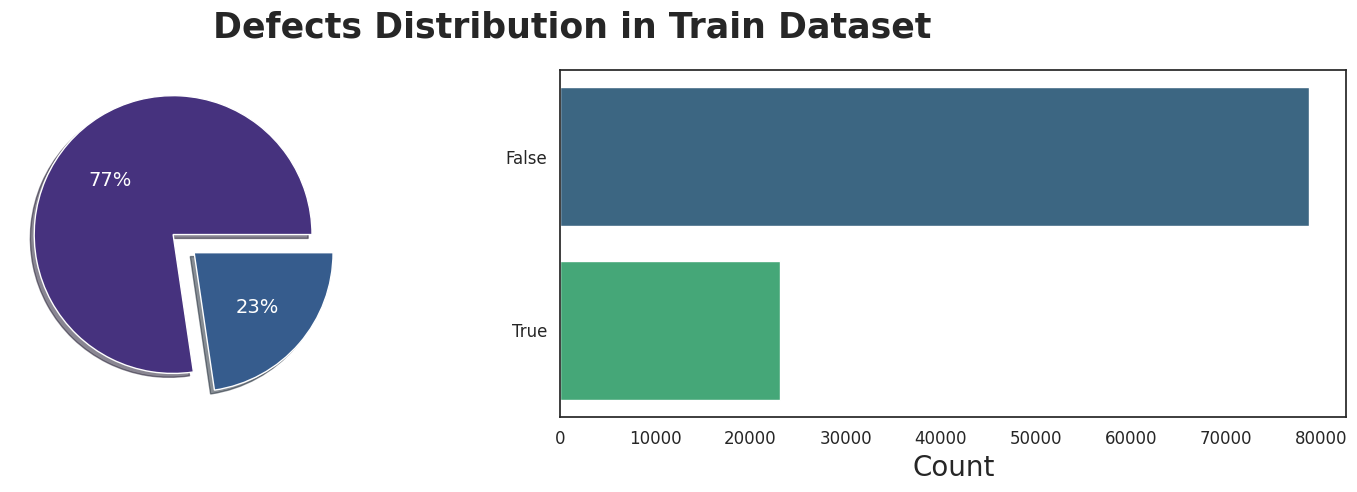

In [17]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
ax = ax.flatten()

ax[0].pie(
    train['defects'].value_counts(), 
    shadow = True, 
    explode = [.1 for i in range(train.defects.nunique())], 
    autopct = '%1.f%%',
    textprops = {'size' : 14, 'color' : 'white'}
)

sns.countplot(data = train, y = 'defects', ax = ax[1], palette = 'viridis', order = train['defects'].value_counts().index)
ax[1].yaxis.label.set_size(20)
plt.yticks(fontsize = 12)
ax[1].set_xlabel('Count', fontsize = 20)
ax[1].set_ylabel(None)
plt.xticks(fontsize = 12)

fig.suptitle('Defects Distribution in Train Dataset', fontsize = 25, fontweight = 'bold')
plt.tight_layout()

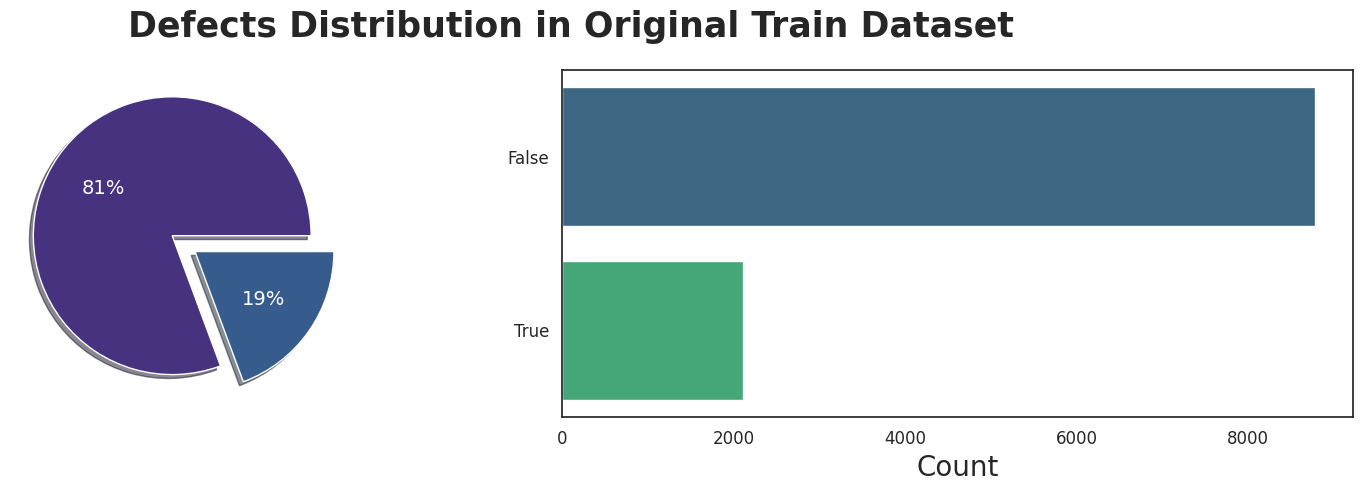

In [18]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
ax = ax.flatten()

ax[0].pie(
    orig_train['defects'].value_counts(), 
    shadow = True, 
    explode = [.1 for i in range(orig_train.defects.nunique())], 
    autopct = '%1.f%%',
    textprops = {'size' : 14, 'color' : 'white'}
)

sns.countplot(data = orig_train, y = 'defects', ax = ax[1], palette = 'viridis', order = orig_train['defects'].value_counts().index)
ax[1].yaxis.label.set_size(20)
plt.yticks(fontsize = 12)
ax[1].set_xlabel('Count', fontsize = 20)
ax[1].set_ylabel(None)
plt.xticks(fontsize = 12)

fig.suptitle('Defects Distribution in Original Train Dataset', fontsize = 25, fontweight = 'bold')
plt.tight_layout()

In [20]:
def heatmap(dataset, label = None):
    corr = dataset.corr(method = 'spearman')
    plt.figure(figsize = (15, 15), dpi = 300)
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask = mask, cmap = 'viridis', annot = True, annot_kws = {'size' : 7})
    plt.title(f'{label} Dataset Correlation Matrix\n', fontsize = 25, weight = 'bold')
    plt.show()

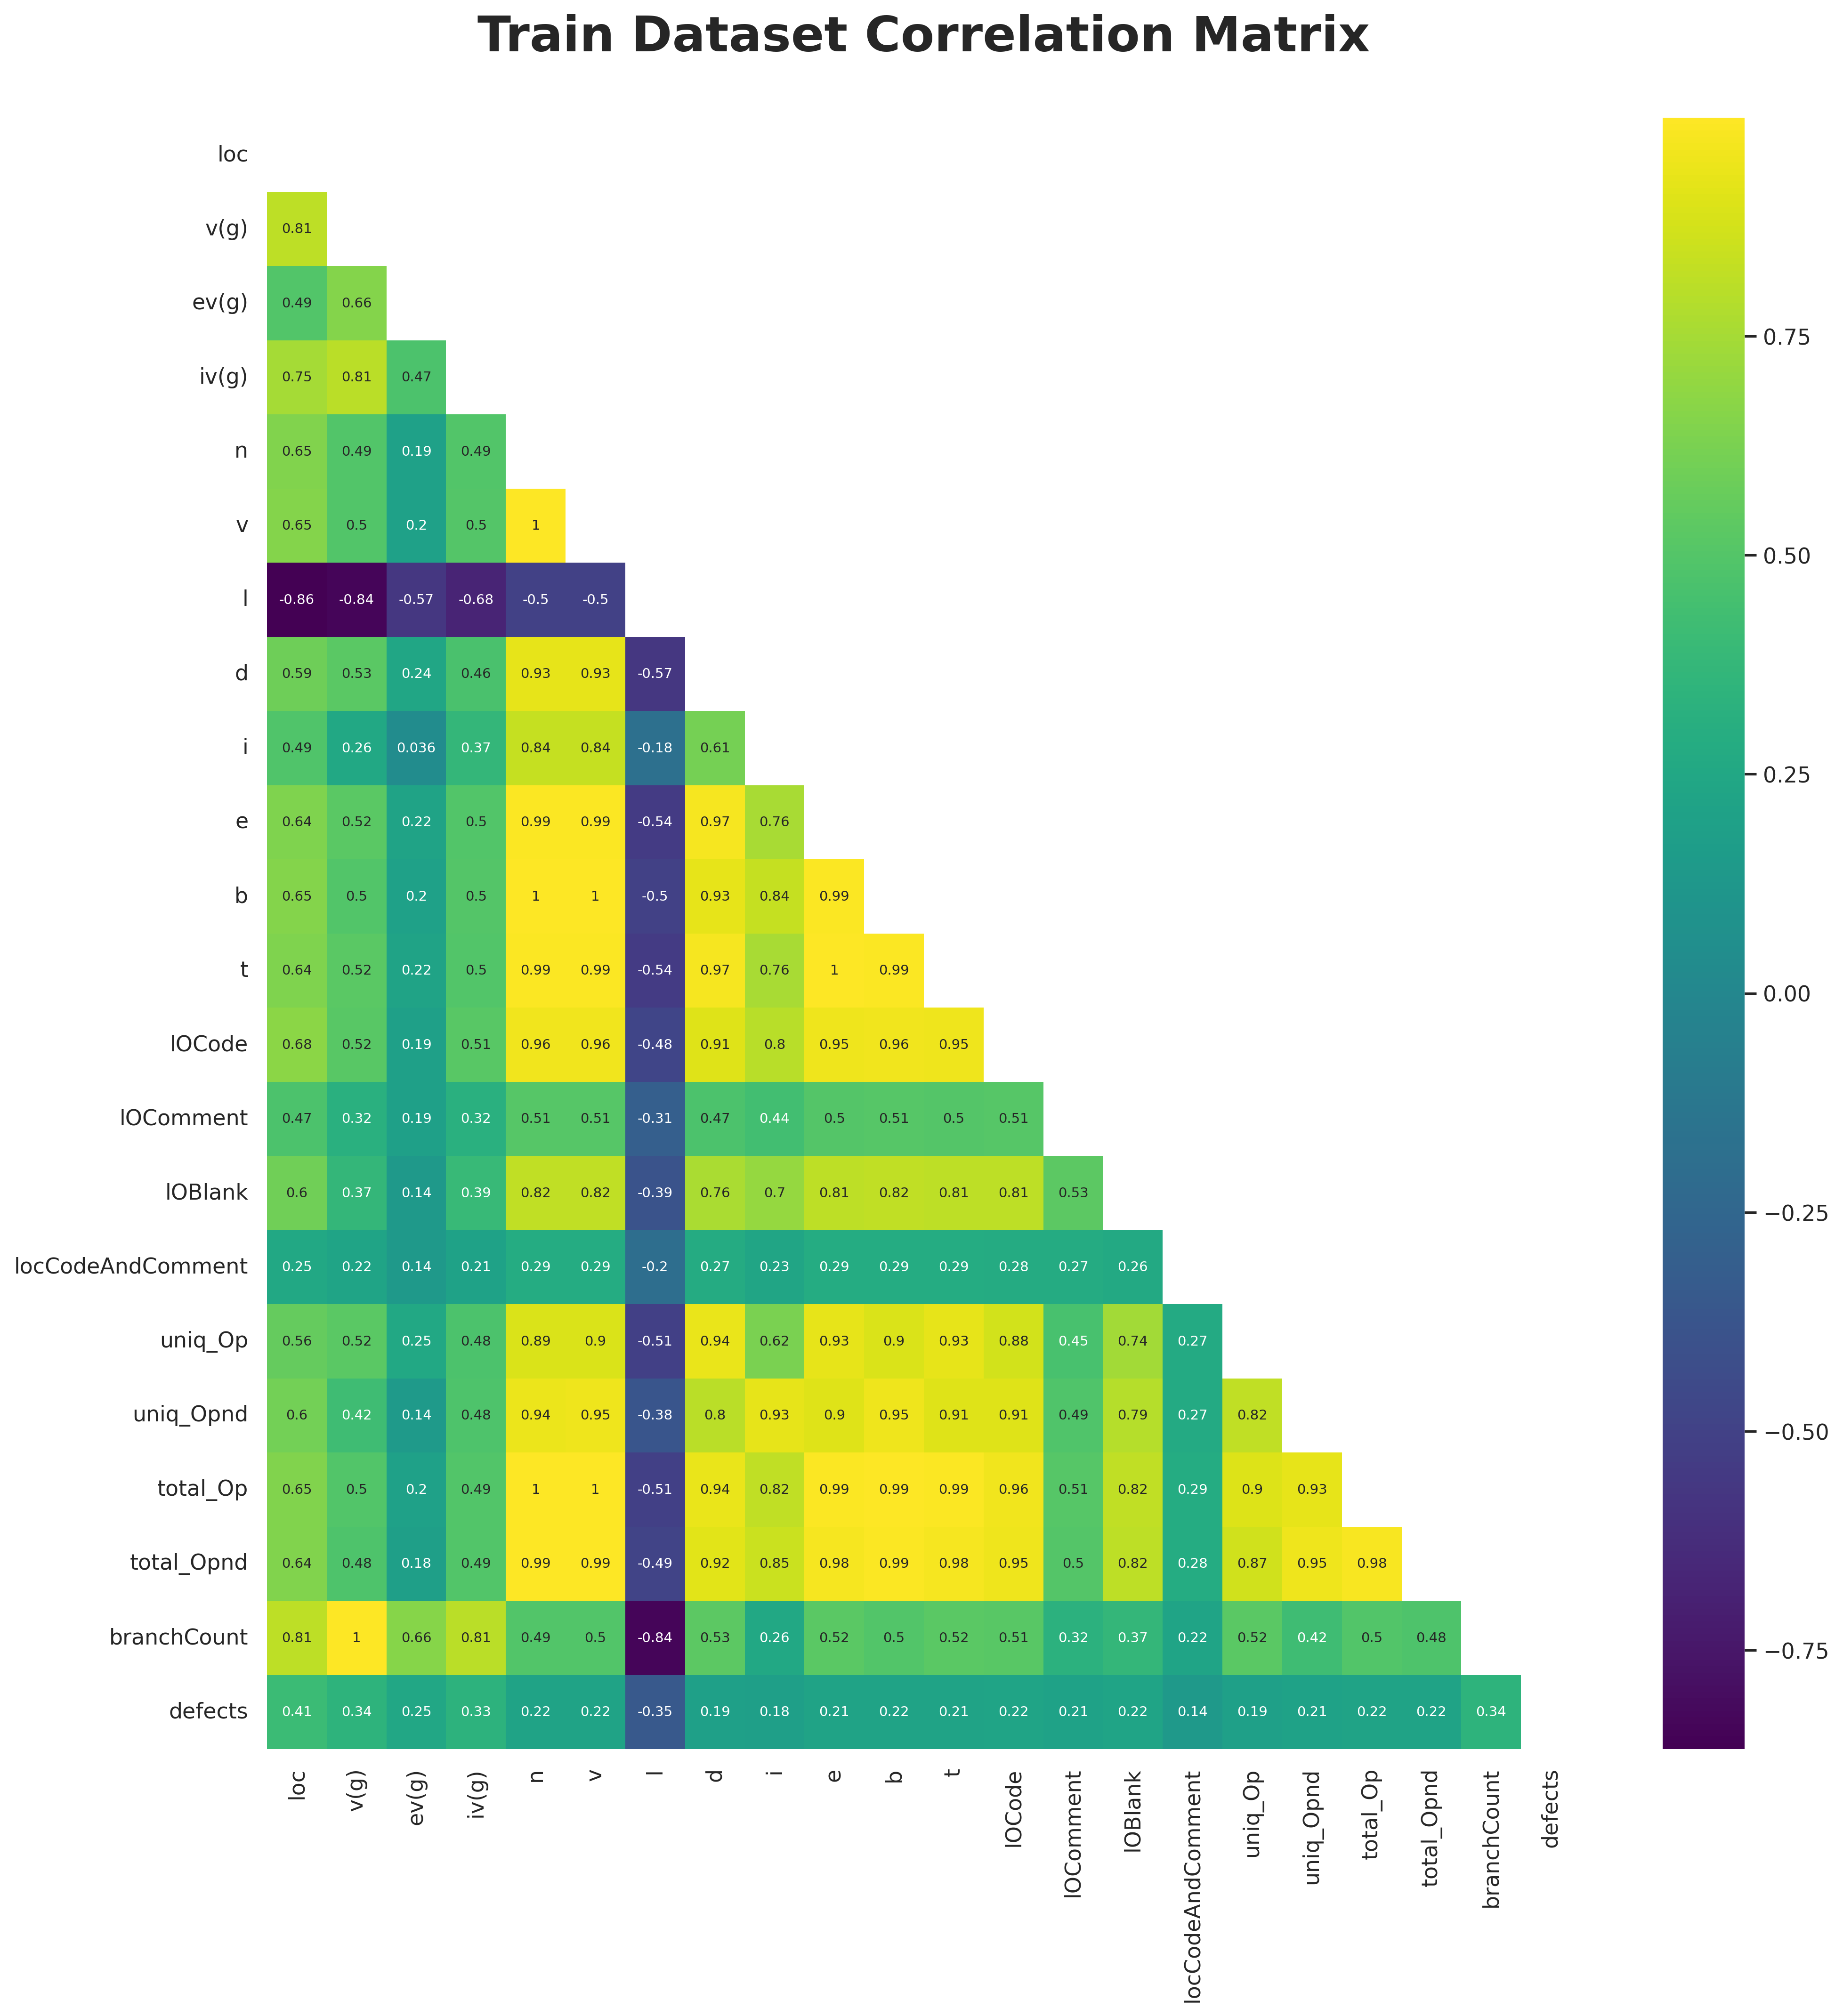

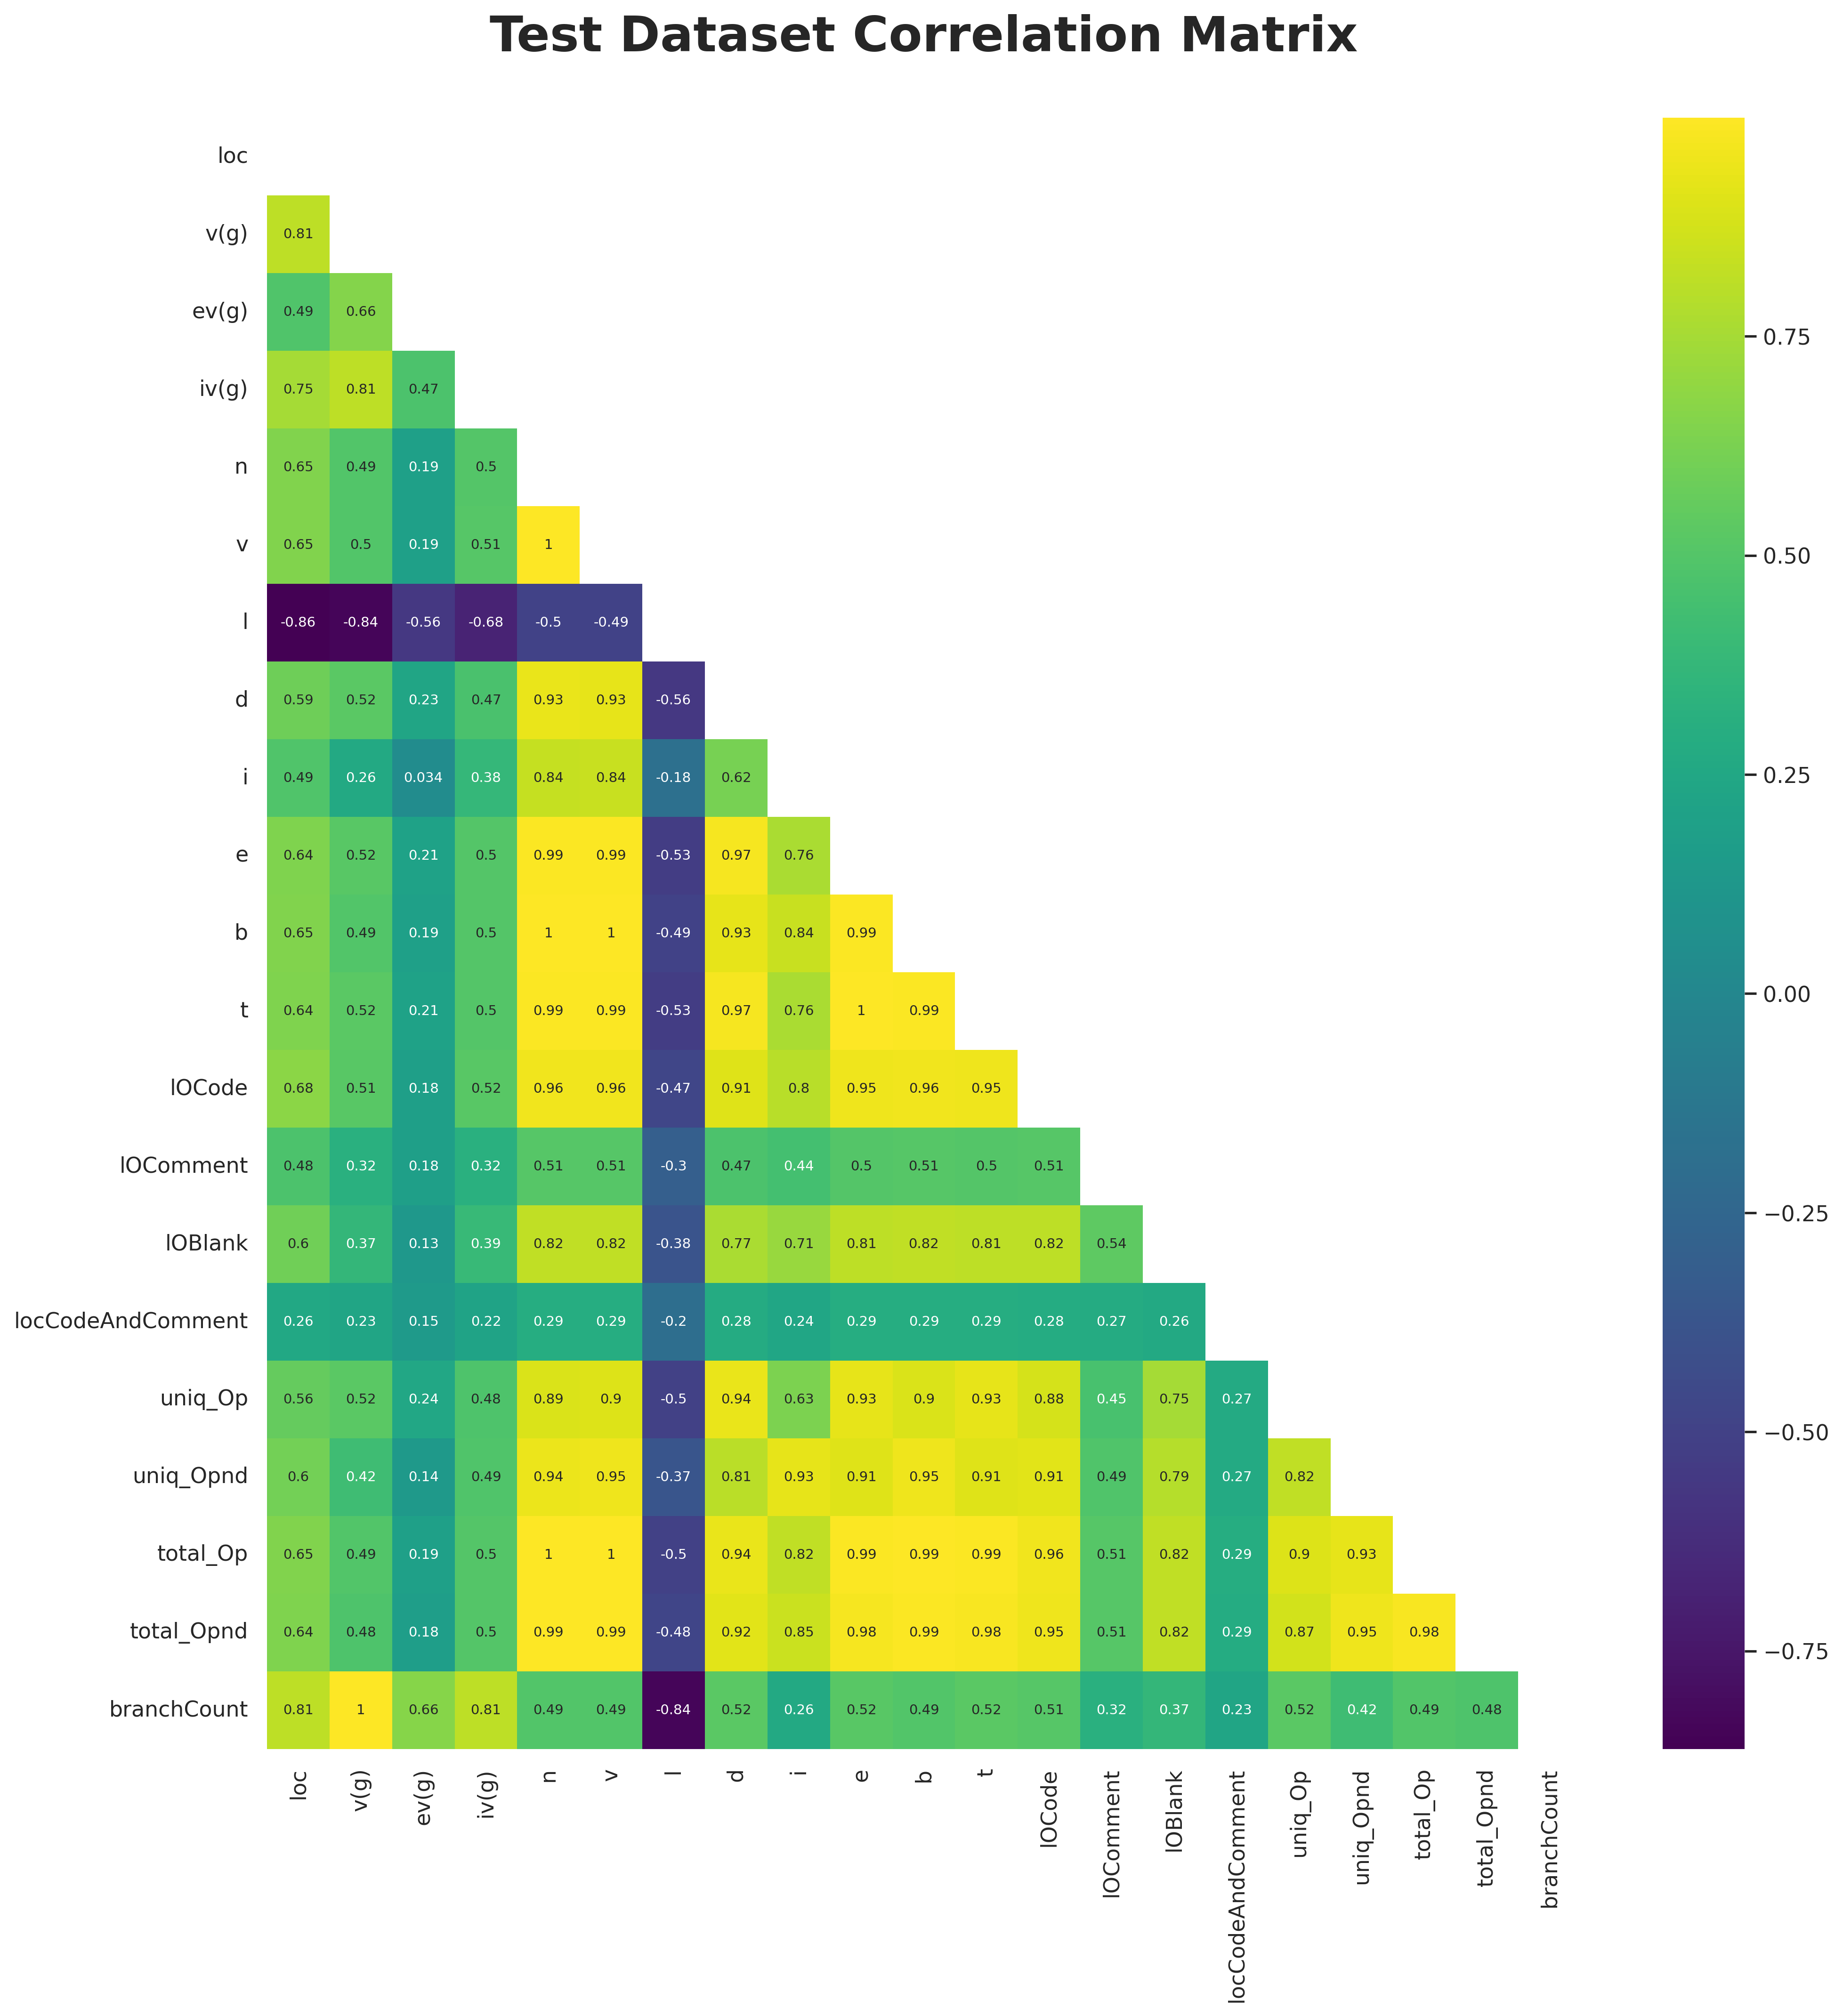

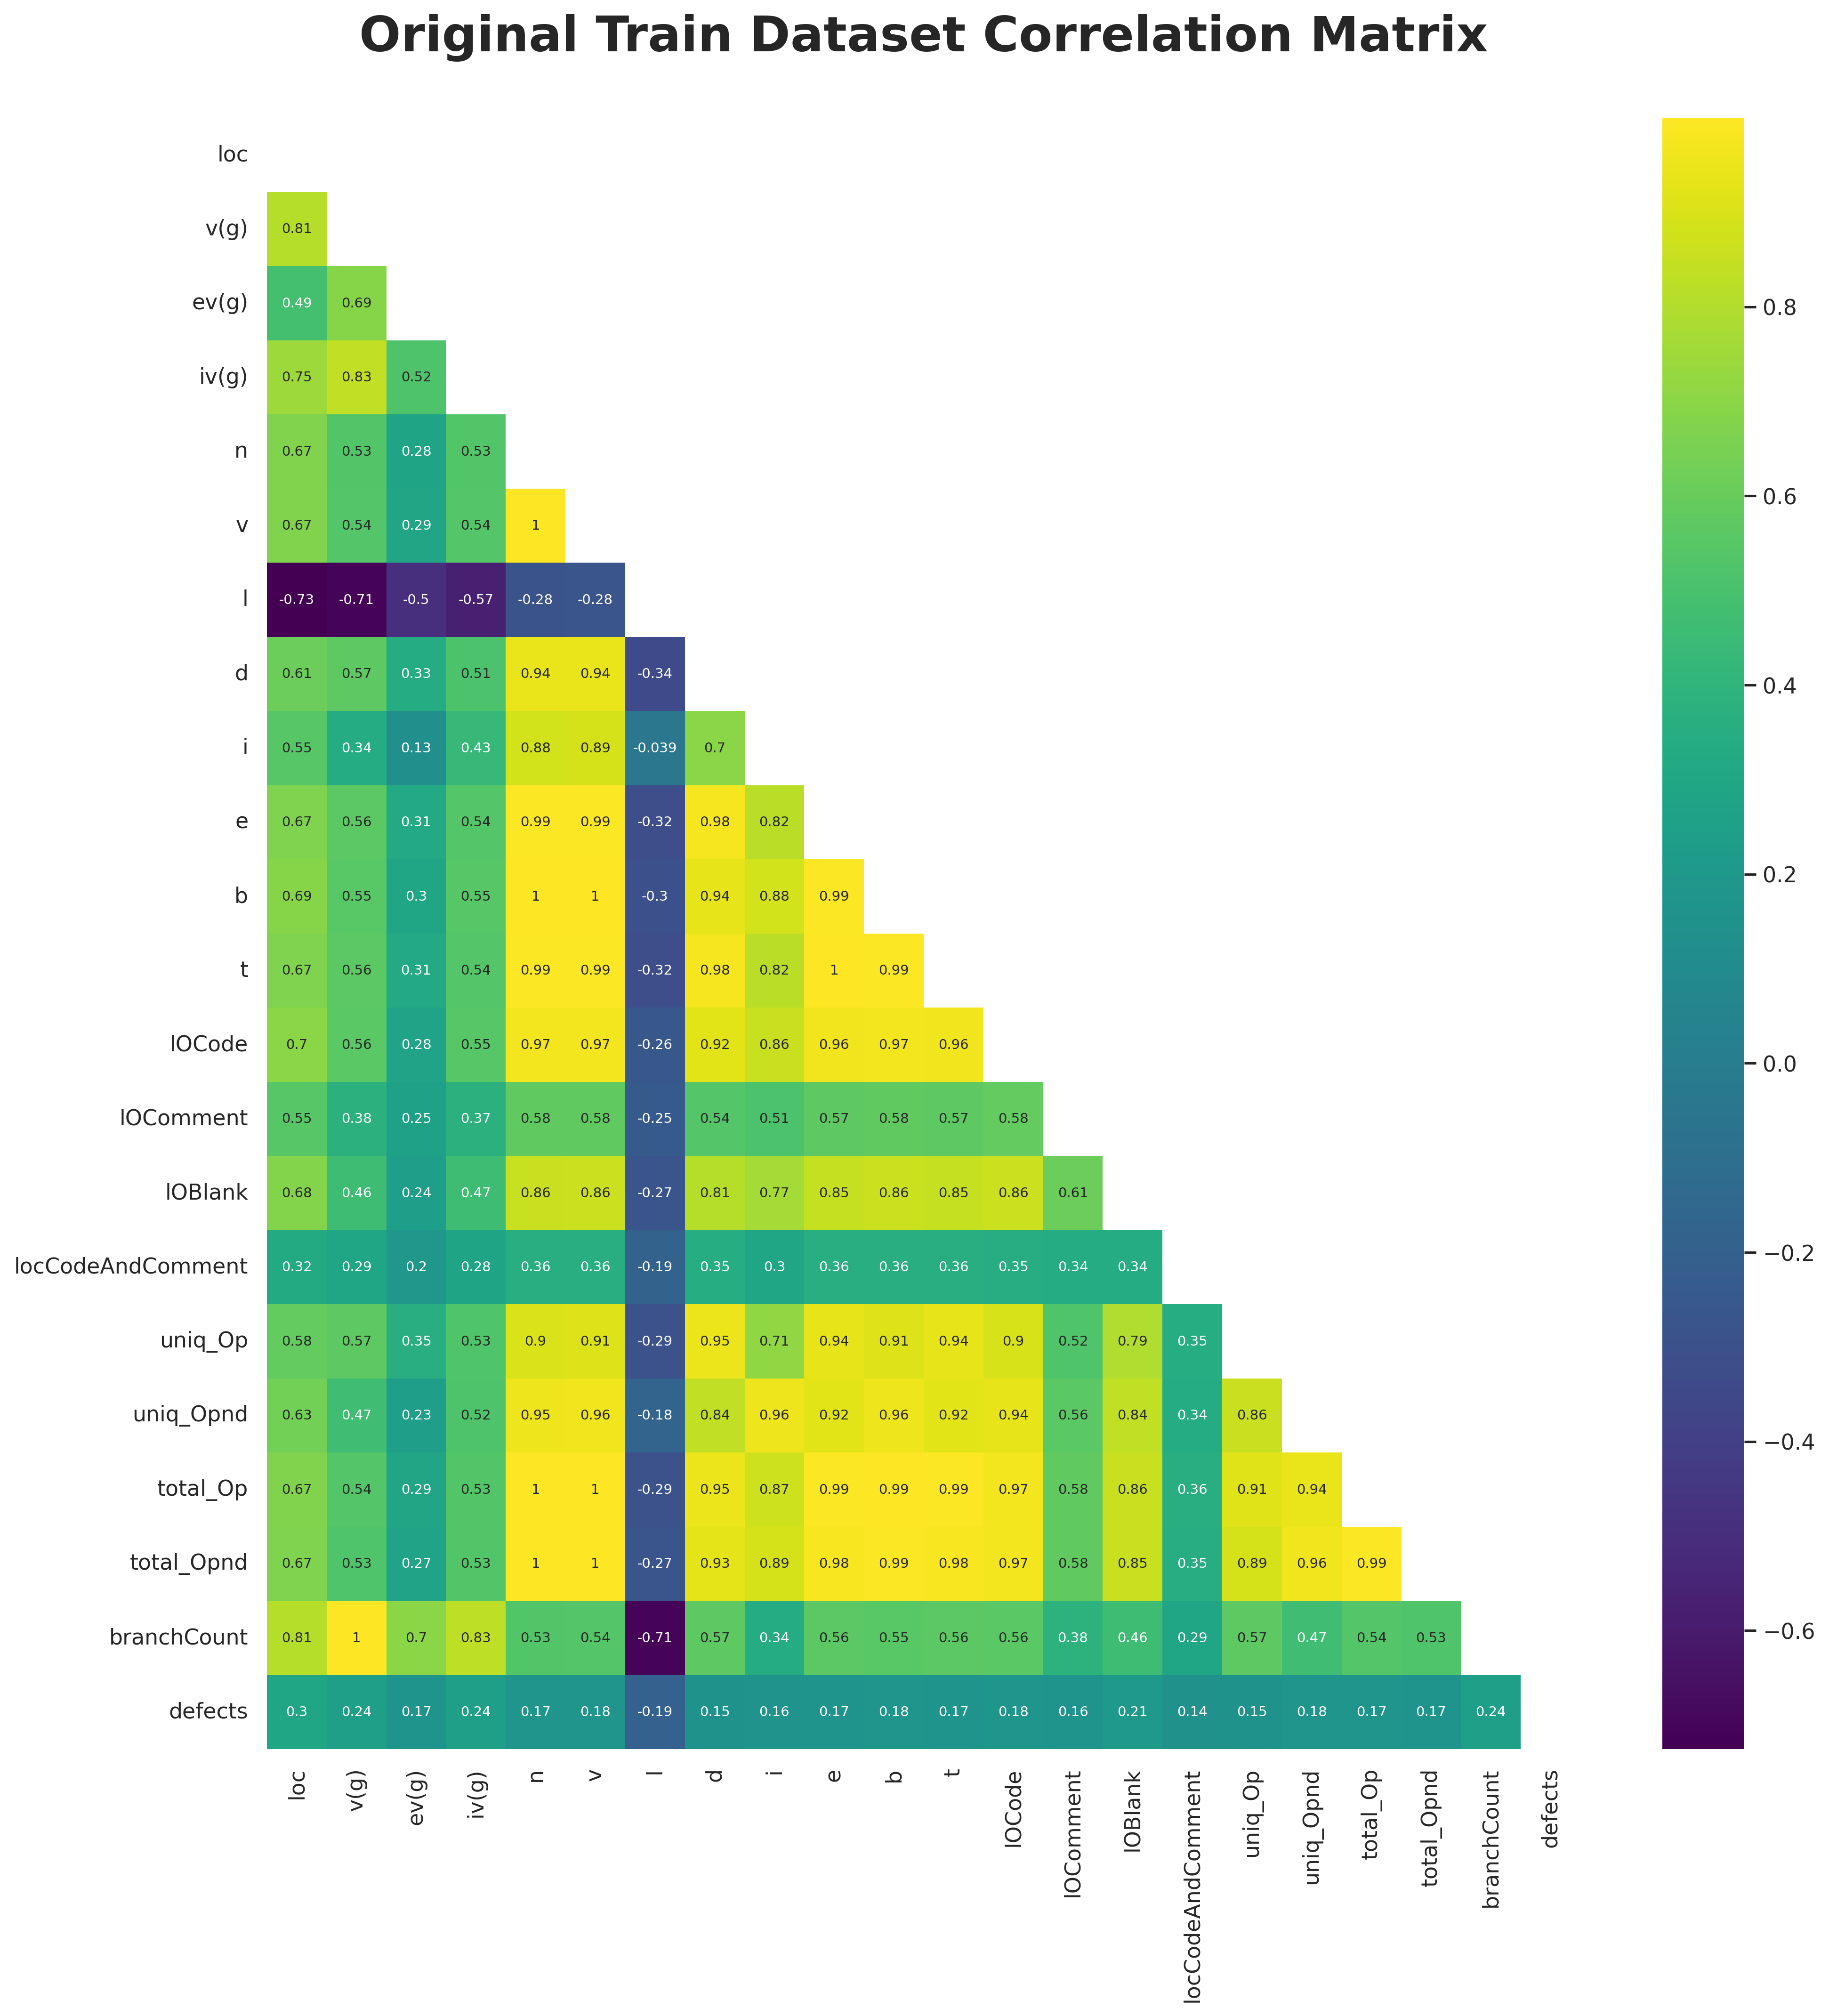

In [21]:
heatmap(train, 'Train')
heatmap(test, 'Test')
heatmap(orig_train, 'Original Train')

In [22]:
def distance(data, label = ''):
    #thanks to @sergiosaharovsky for the fix
    corr = data.corr(method = 'spearman')
    dist_linkage = linkage(squareform(1 - abs(corr)), 'complete')
    
    plt.figure(figsize = (10, 8), dpi = 300)
    dendro = dendrogram(dist_linkage, labels=data.columns, leaf_rotation=90)
    plt.title(f'Feature Distance in {label} Dataset', weight = 'bold', size = 20)
    plt.show()

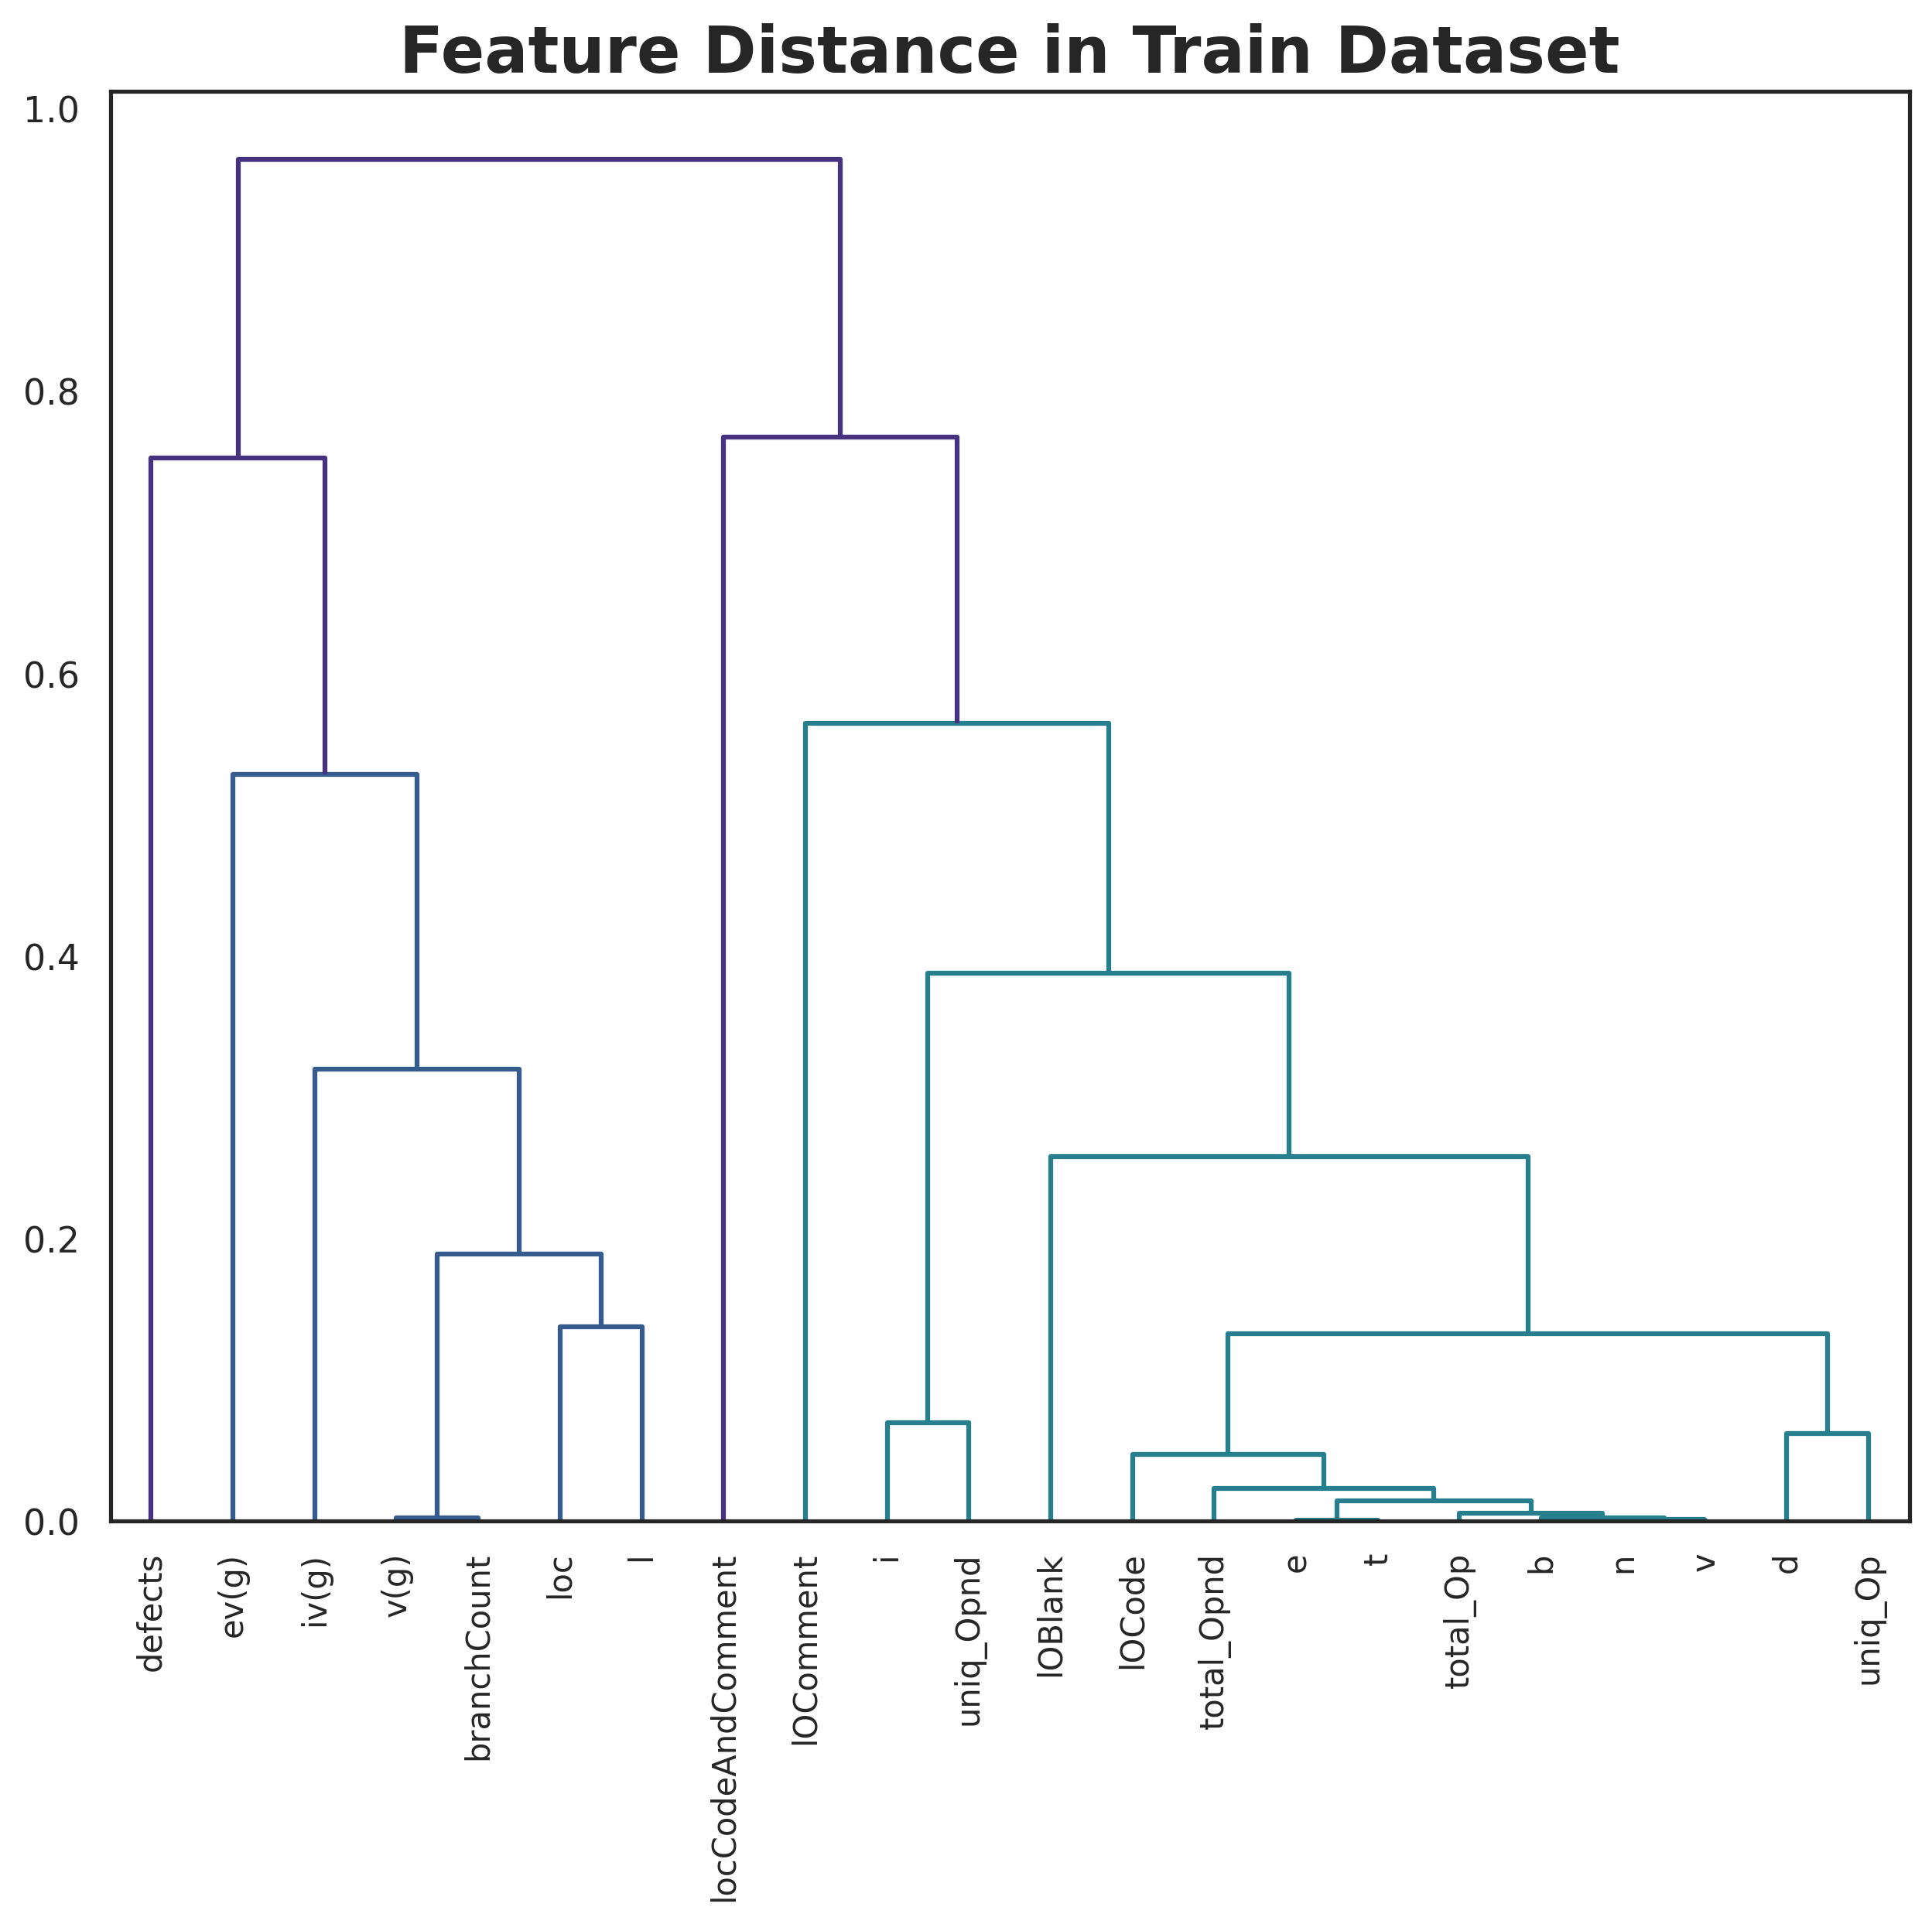

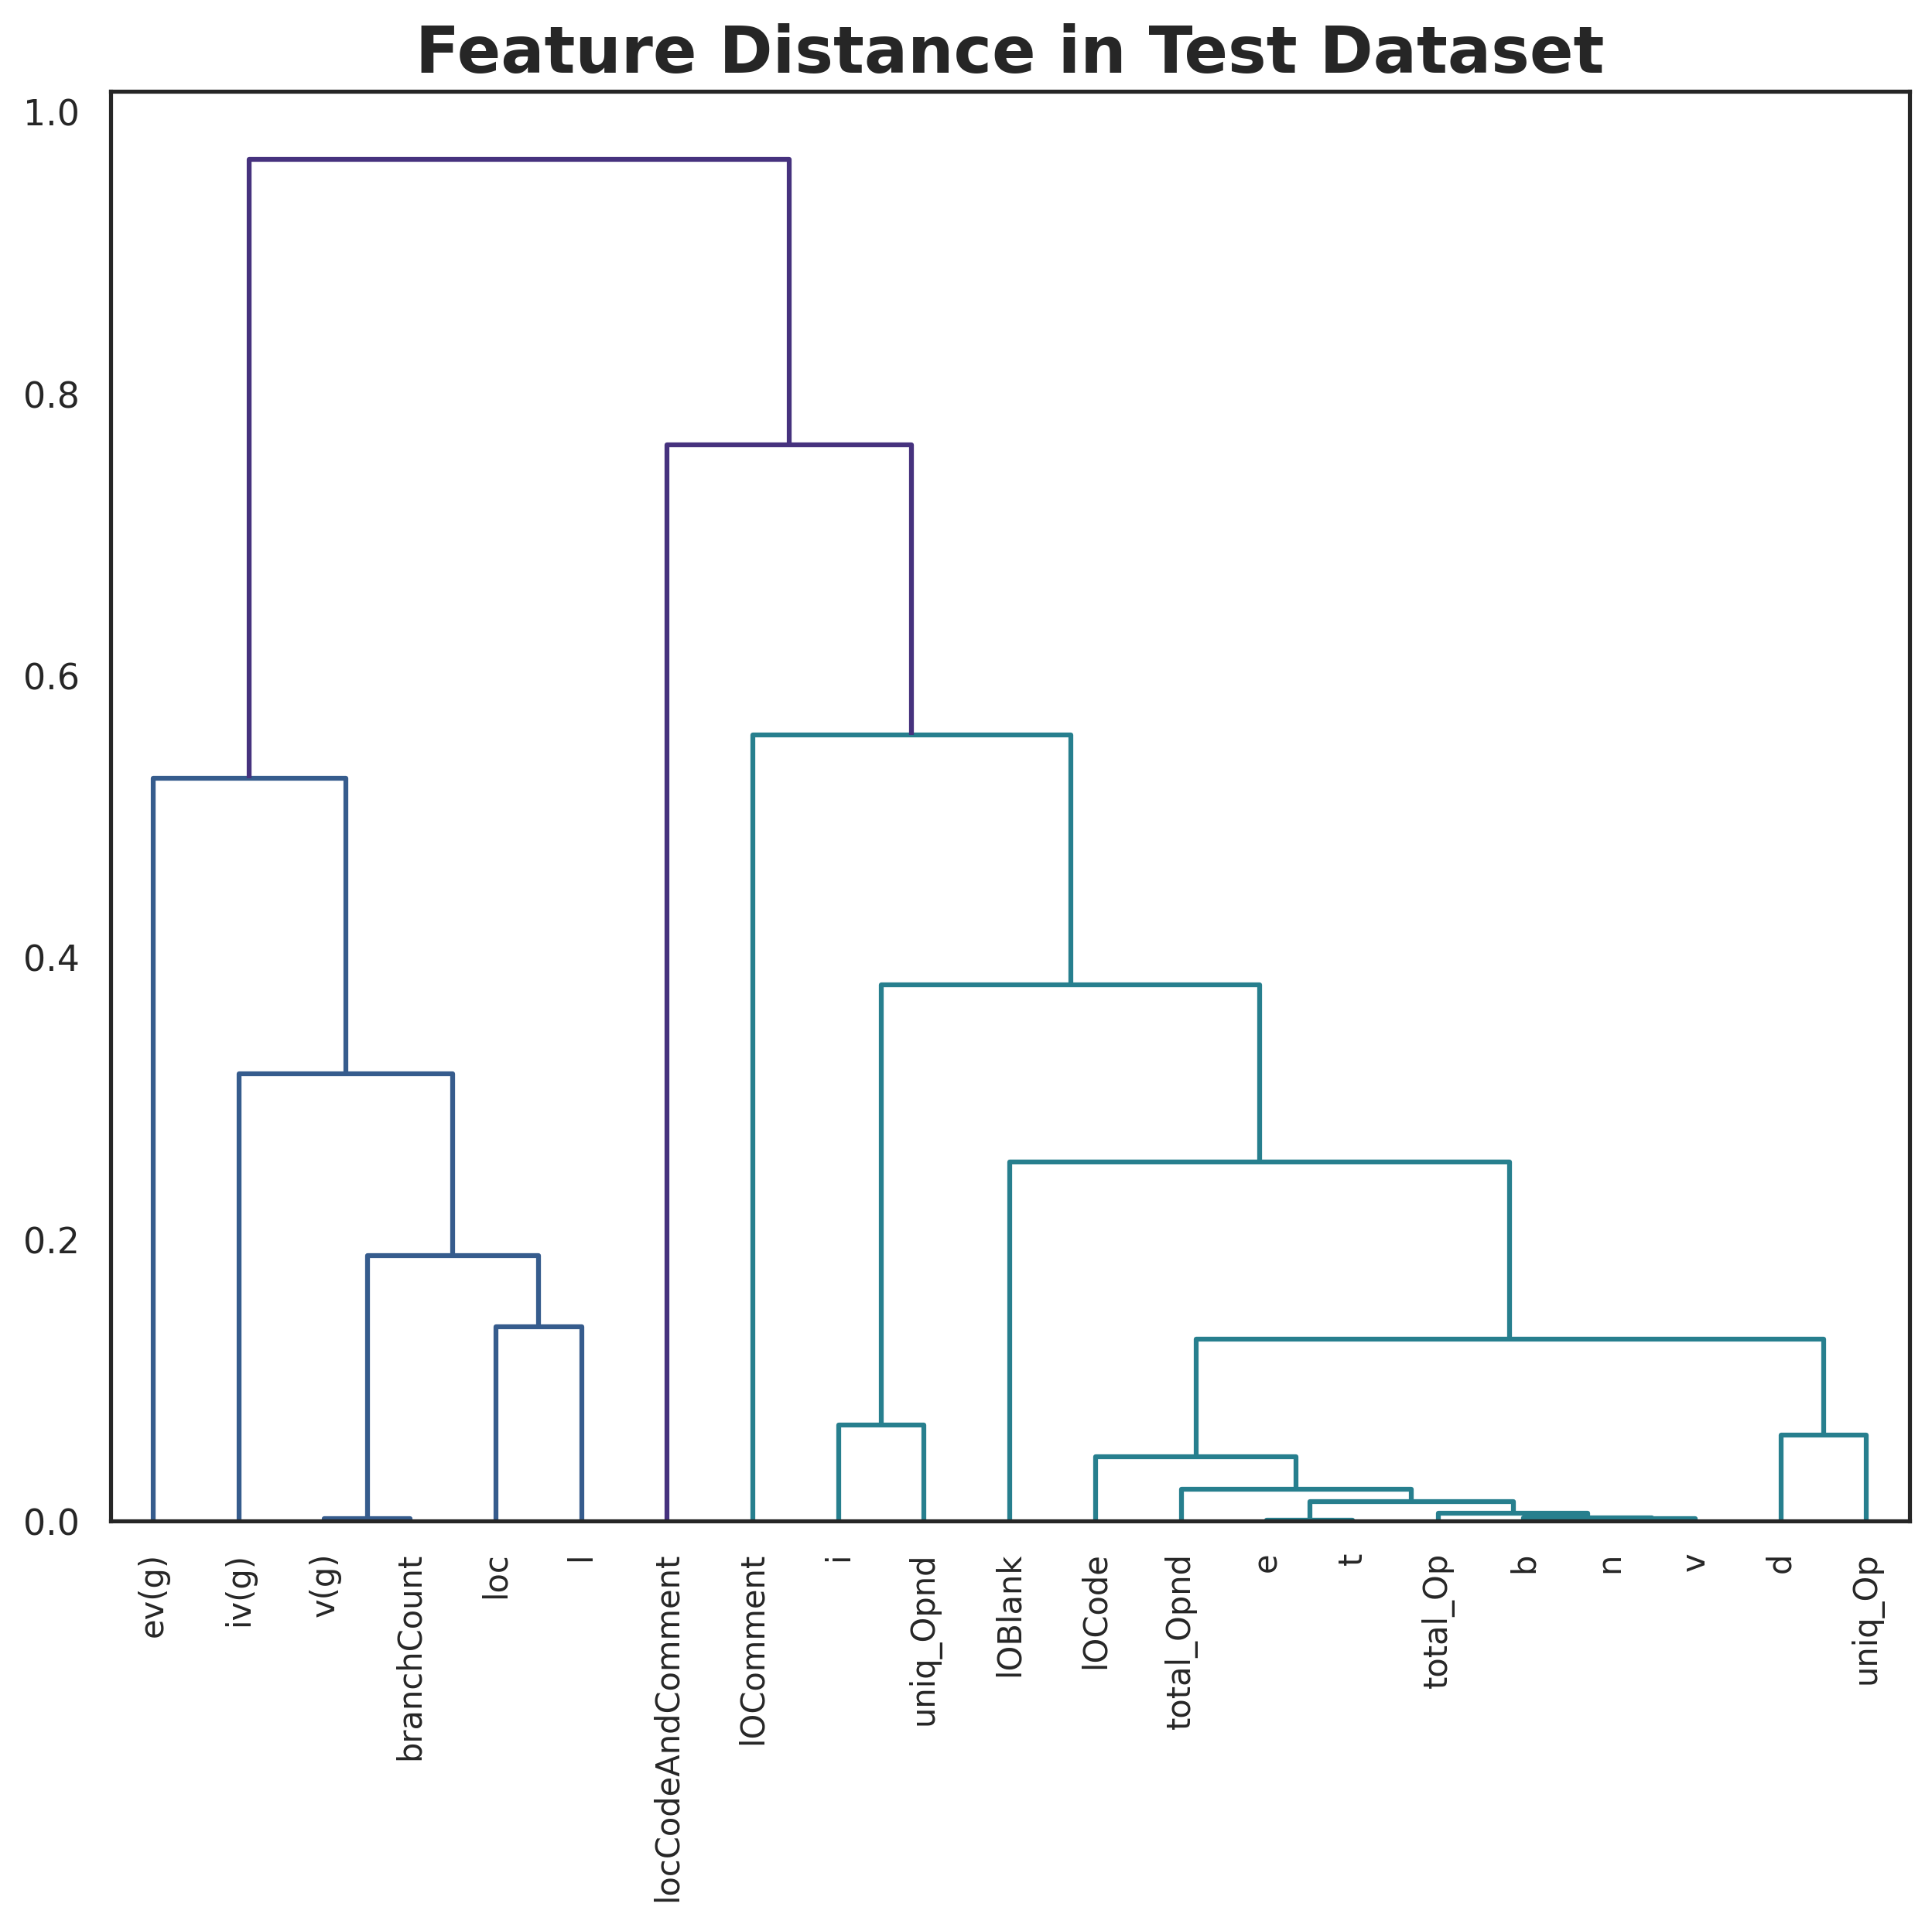

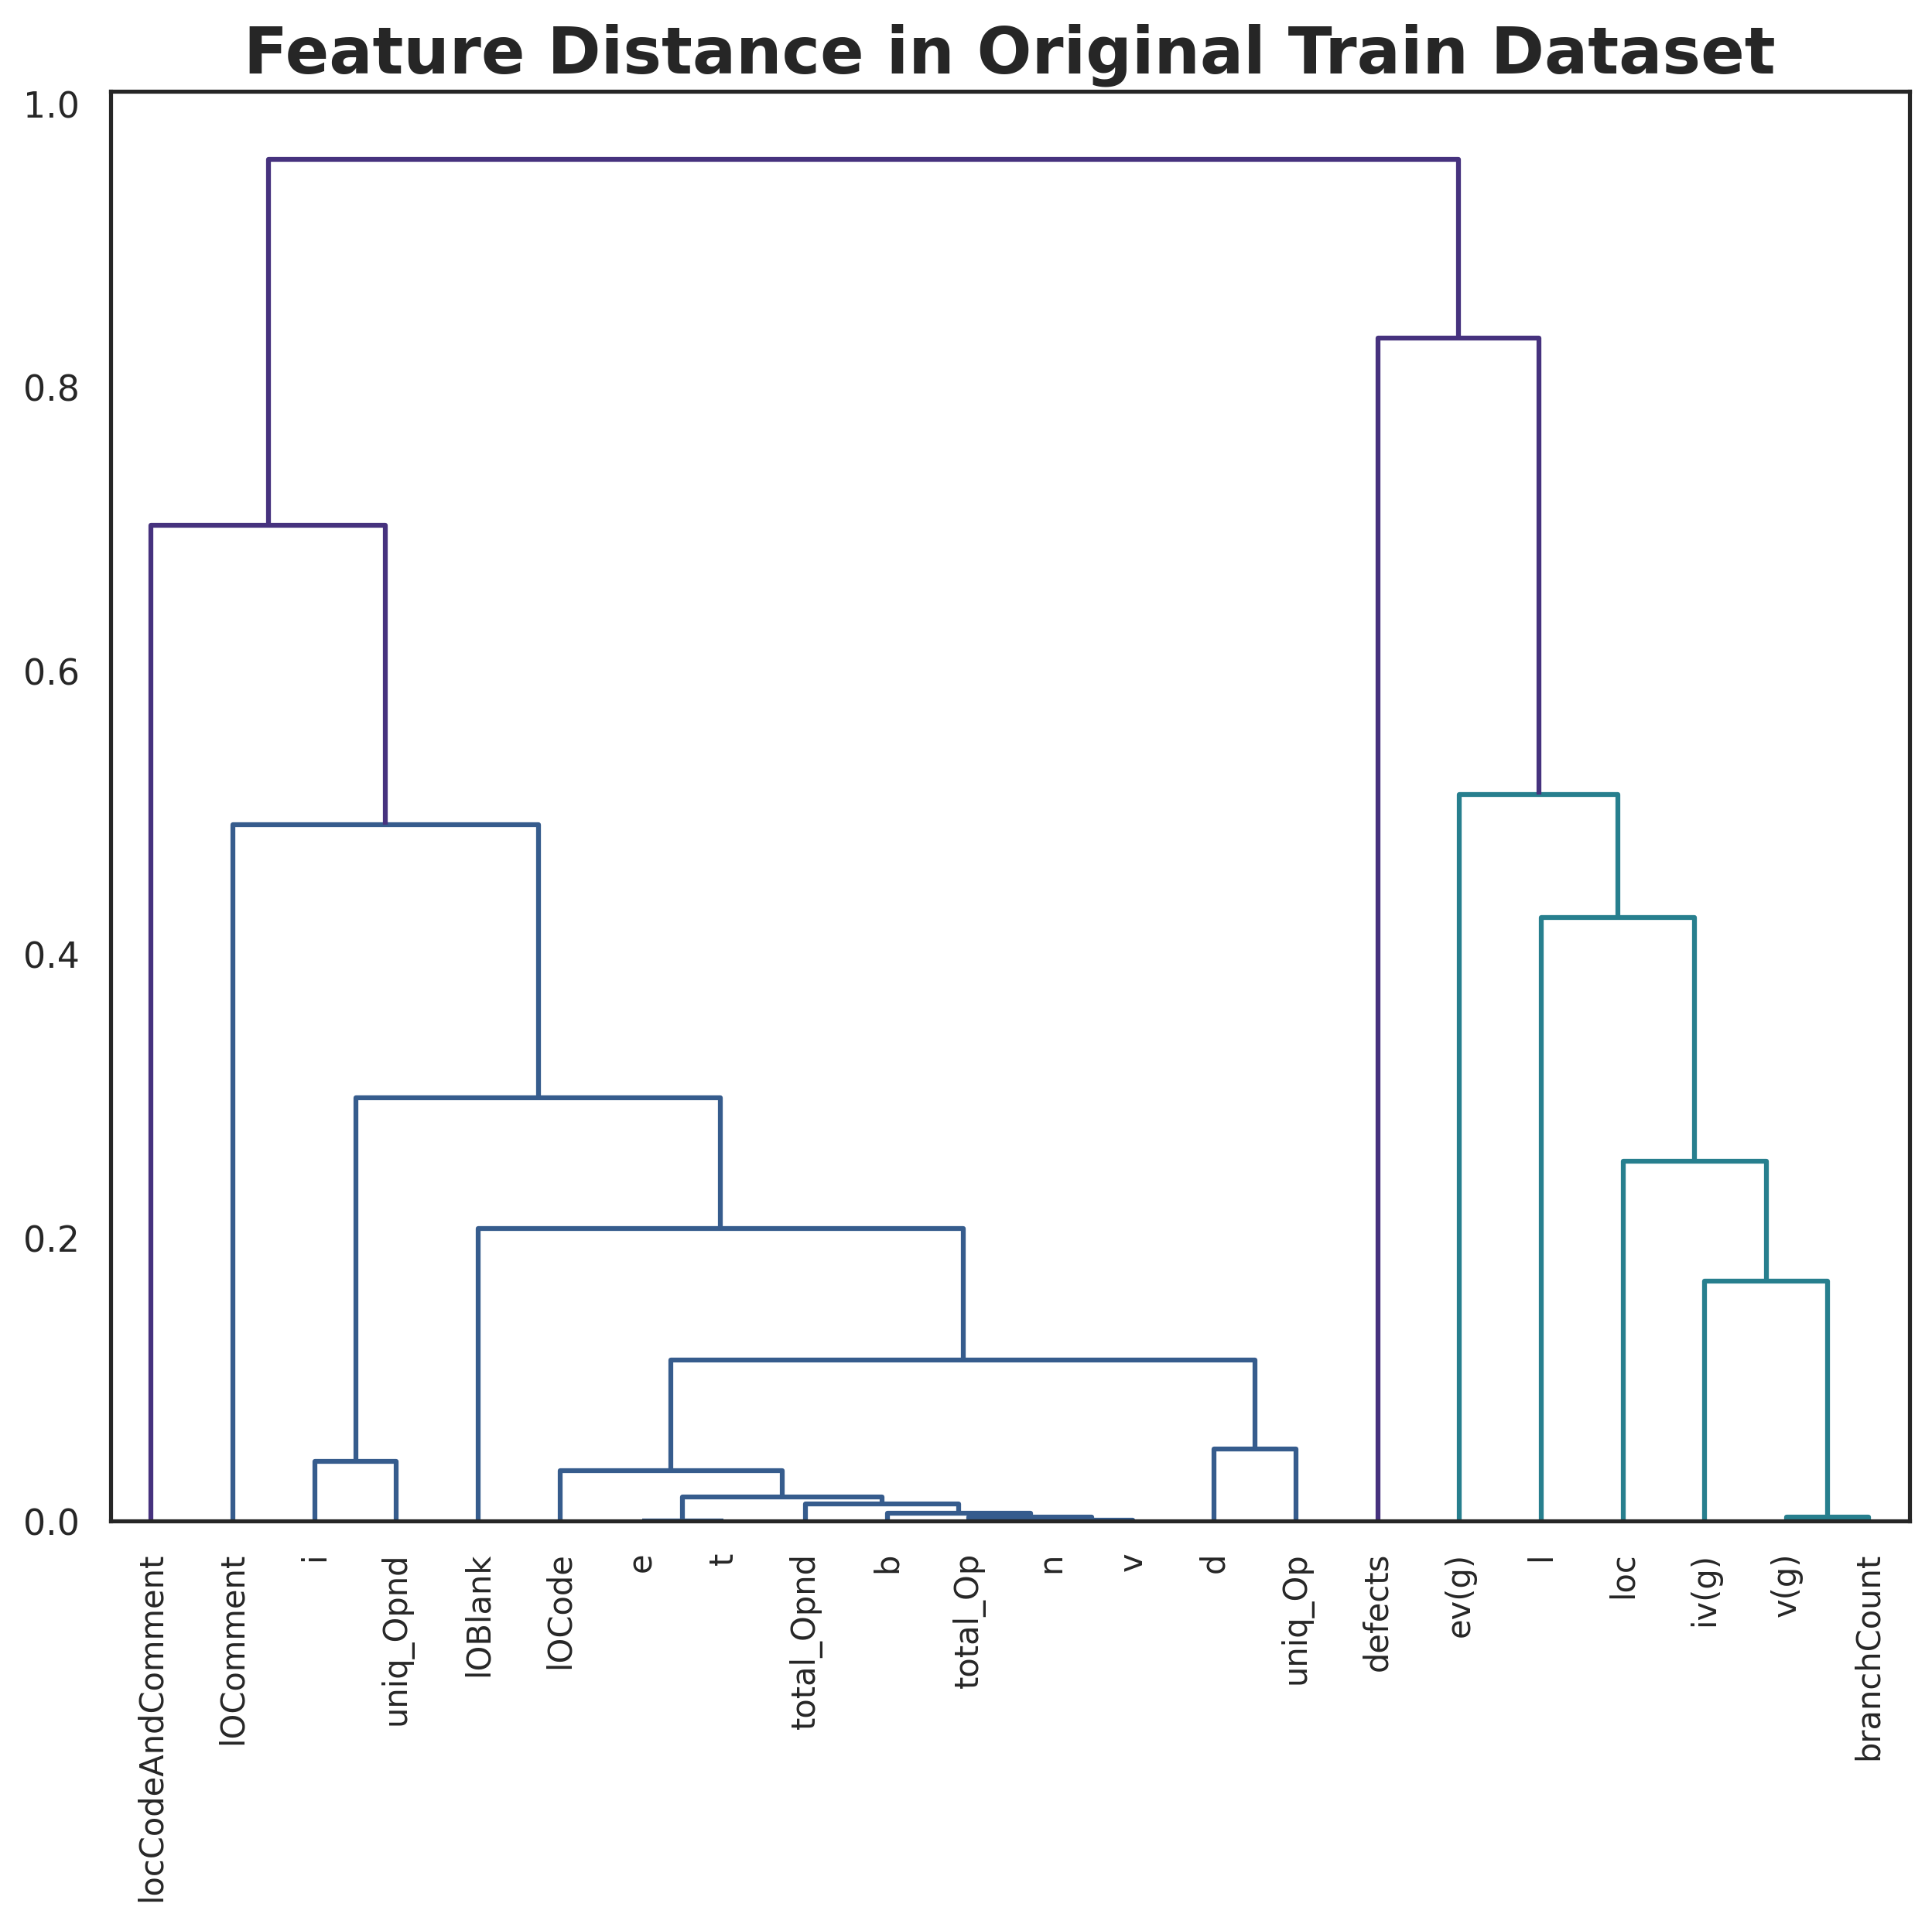

In [23]:
distance(train, 'Train')
distance(test, 'Test')
distance(orig_train, 'Original Train')

In [24]:
X = pd.concat([train, orig_train])
y = X.pop('defects')

seed = 42
splits = 5
skf = StratifiedKFold(n_splits = splits, random_state = seed, shuffle = True)
np.random.seed(seed)

In [25]:
def cross_val_score(estimator, cv = skf, label = '', include_original = False):
    
    X = train.copy()
    y = X.pop('defects')
    
    #initiate prediction arrays and score lists
    val_predictions = np.zeros((len(X)))
    #train_predictions = np.zeros((len(sample)))
    train_scores, val_scores = [], []
    
    #training model, predicting prognosis probability, and evaluating metrics
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        
        model = clone(estimator)
        
        #define train set
        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]
        
        #define validation set
        X_val = X.iloc[val_idx]
        y_val = y.iloc[val_idx]
        
        if include_original:
            X_train = pd.concat([X_train, orig_train.drop('defects', axis = 1)])
            y_train = pd.concat([y_train, orig_train.defects])
        
        #train model
        model.fit(X_train, y_train)
        
        #make predictions
        train_preds = model.predict_proba(X_train)[:, 1]
        val_preds = model.predict_proba(X_val)[:, 1]
        
        val_predictions[val_idx] += val_preds
        
        #evaluate model for a fold
        train_score = roc_auc_score(y_train, train_preds)
        val_score = roc_auc_score(y_val, val_preds)
        
        #append model score for a fold to list
        train_scores.append(train_score)
        val_scores.append(val_score)
    
    print(f'Val Score: {np.mean(val_scores):.5f} ± {np.std(val_scores):.5f} | Train Score: {np.mean(train_scores):.5f} ± {np.std(train_scores):.5f} | {label}')
    
    return val_scores, val_predictions

In [26]:
score_list, oof_list = pd.DataFrame(), pd.DataFrame()

models = [
    ('log', LogisticRegression(random_state = seed, max_iter = 1000000)),
    ('lda', LinearDiscriminantAnalysis()),
    ('gnb', GaussianNB()),
    ('bnb', BernoulliNB()),
    ('knn', KNeighborsClassifier()),
    ('rf', RandomForestClassifier(random_state = seed)),
    ('et', ExtraTreesClassifier(random_state = seed)),
    ('xgb', XGBClassifier(random_state = seed)),
    ('lgb', LGBMClassifier(random_state = seed)),
    ('dart', LGBMClassifier(random_state = seed, boosting_type = 'dart')),
    ('cb', CatBoostClassifier(random_state = seed, verbose = 0)),
    ('gb', GradientBoostingClassifier(random_state = seed)),
    ('hgb', HistGradientBoostingClassifier(random_state = seed)),
]

for (label, model) in models:
    score_list[label], oof_list[label] = cross_val_score(
        make_pipeline(SimpleImputer(), model),
        label = label,
        include_original = True
    )

Val Score: 0.64834 ± 0.01373 | Train Score: 0.63994 ± 0.01190 | log
Val Score: 0.77764 ± 0.00345 | Train Score: 0.76936 ± 0.00097 | lda
Val Score: 0.76963 ± 0.00439 | Train Score: 0.75897 ± 0.00046 | gnb
Val Score: 0.68332 ± 0.00334 | Train Score: 0.67340 ± 0.00073 | bnb
Val Score: 0.70884 ± 0.00349 | Train Score: 0.87489 ± 0.00094 | knn
Val Score: 0.76402 ± 0.00320 | Train Score: 0.99930 ± 0.00003 | rf
Val Score: 0.75292 ± 0.00280 | Train Score: 0.99994 ± 0.00000 | et
Val Score: 0.78566 ± 0.00391 | Train Score: 0.84022 ± 0.00165 | xgb
Val Score: 0.79134 ± 0.00354 | Train Score: 0.80905 ± 0.00115 | lgb
Val Score: 0.79185 ± 0.00337 | Train Score: 0.79437 ± 0.00076 | dart
Val Score: 0.78996 ± 0.00348 | Train Score: 0.82513 ± 0.00054 | cb
Val Score: 0.79170 ± 0.00329 | Train Score: 0.78909 ± 0.00081 | gb
Val Score: 0.79132 ± 0.00356 | Train Score: 0.80231 ± 0.00284 | hgb


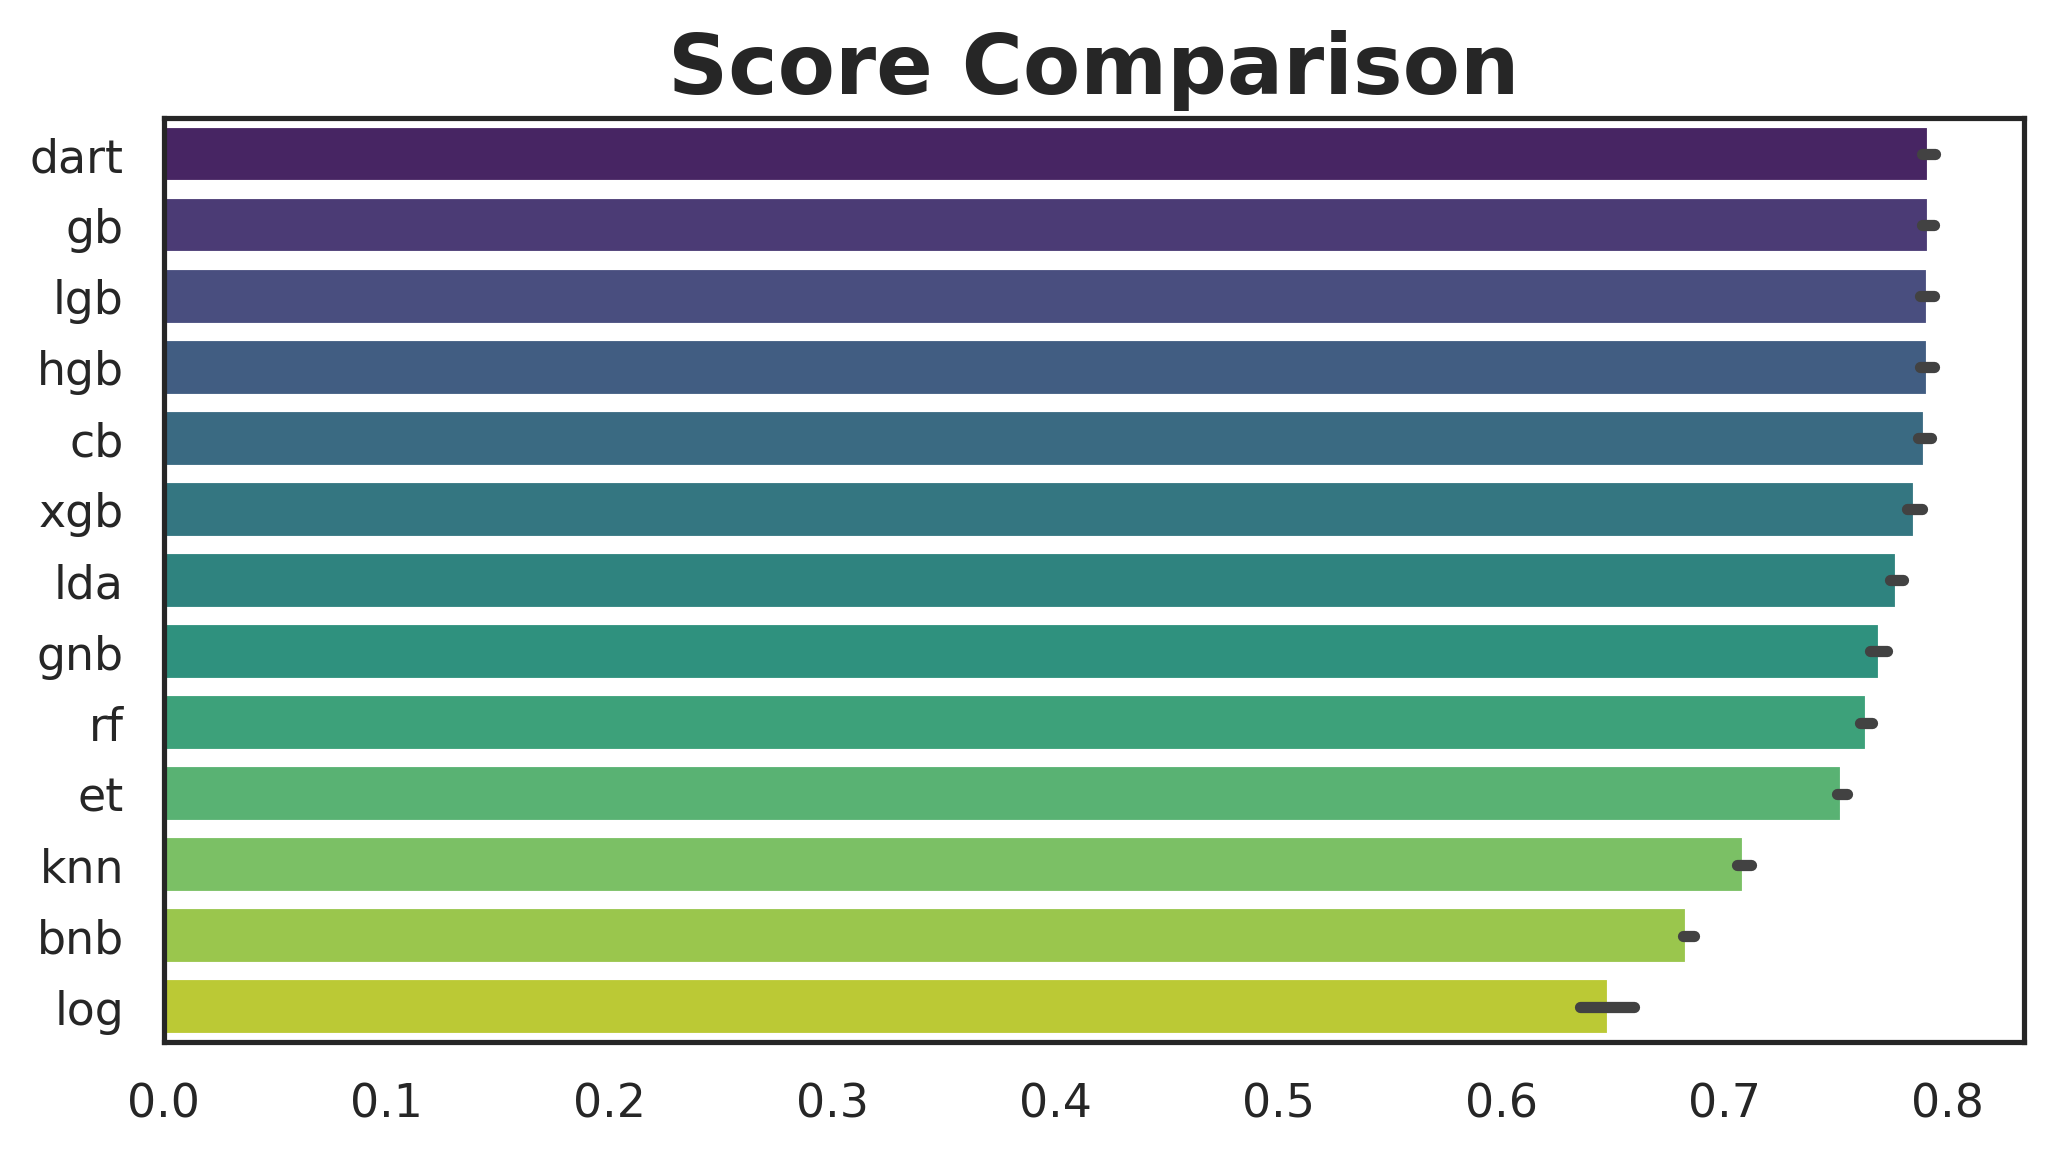

In [27]:
plt.figure(figsize = (8, 4), dpi = 300)
sns.barplot(data = score_list.reindex((-1 * score_list).mean().sort_values().index, axis = 1), palette = 'viridis', orient = 'h')
plt.title('Score Comparison', weight = 'bold', size = 20)
plt.show()

In [28]:
weights = RidgeClassifier(random_state = seed).fit(oof_list, train.defects).coef_[0]
pd.DataFrame(weights, index = list(oof_list), columns = ['weight per model'])


weight per model
log           0.007757
lda           0.057639
gnb           0.001108
bnb          -0.010990
knn           0.050602
rf            0.099963
et           -0.119508
xgb           0.106524
lgb           0.158259
dart          0.742149
cb            0.246950
gb            0.643250
hgb           0.188423

In [29]:
voter = VotingClassifier(models, weights = weights, voting = 'soft')
_ = cross_val_score(
    make_pipeline(SimpleImputer(), voter),
    include_original = True
)

Val Score: 0.79255 ± 0.00332 | Train Score: 0.76866 ± 0.00100 | 


In [30]:
model = make_pipeline(
    SimpleImputer(),
    voter
)

model.fit(X, y)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('votingclassifier',
                 VotingClassifier(estimators=[('log',
                                               LogisticRegression(max_iter=1000000,
                                                                  random_state=42)),
                                              ('lda',
                                               LinearDiscriminantAnalysis()),
                                              ('gnb', GaussianNB()),
                                              ('bnb', BernoulliNB()),
                                              ('knn', KNeighborsClassifier()),
                                              ('rf',
                                               RandomForestClassifier(random_state=42)),
                                              ('et',
                                               ExtraTreesClassifier(rando...
                                                              random_state=42)),
                                              ('cb',
                                               <catboost.core.CatBoostClassifier object at 0x7c72c058d930>),
                                              ('gb',
                                               GradientBoostingClassifier(random_state=42)),
                                              ('hgb',
                                               HistGradientBoostingClassifier(random_state=42))],
                                  voting='soft',
                                  weights=array([ 0.00775681,  0.0576394 ,  0.00110841, -0.01098963,  0.05060211,
        0.09996332, -0.11950815,  0.10652425,  0.15825907,  0.7421488 ,
        0.24694966,  0.6432503 ,  0.18842349])))])